# Download dataset

In [ ]:
!curl -L -o ./datatset.zip https://www.kaggle.com/api/v1/datasets/download/adhoppin/blood-cell-detection-datatset
!unzip ./datatset.zip -d datasets
!rm ./datatset.zip

In [ ]:
import yaml

with open("datasets/data.yaml", "r") as file:
    data = yaml.safe_load(file)

data["test"] = "../test/images"

with open("datasets/data.yaml", "w") as file:
    yaml.dump(data, file, sort_keys=False)

# Utils

In [ ]:
from IPython.display import display, HTML
import numpy as np
import io
from PIL import Image
import base64

def image_to_base64(img_array):
    img = Image.fromarray(img_array[..., ::-1])
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG")
    base64_img = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return base64_img


def plot(inference_results, cols=3):
    html = "<table><tr>"
    for i, result in enumerate(inference_results):
        img_array = result.plot()
        base64_img = image_to_base64(img_array)

        html += f"<td style='padding:5px'><img src='data:image/jpeg;base64,{base64_img}'></td>"

        if (i + 1) % cols == 0:
            html += "</tr><tr>"

    html += "</tr></table>"
    display(HTML(html))

# Insight into the data

### This is not the original data

In ‘README.dataset.txt’ there is a quote: 

> ‘`Fork` this dataset (top right corner) to receive the raw images, or (to save space) grab the 500x500 export.’.

This is odd. There is no such thing on Kaggle. A quick web search leads to: https://public.roboflow.com/object-detection/bccd/3 . There is the original data where the images are 640x480 in size. Further analysis reveals that there are 765 files in the Kaggle training set and 255 in the original. The reason is that in Kaggle the data already has the data augmentation burned in. This is a shame - I much prefer to work with the data pipeline completely under my control and test the augmentations myself to achieve the best result. 

Because of the explicit instruction in the task to use the Kaggle database I will not be using the original database. (Although I would recommend this in a professional situation).

### Labelling quality

It seems to be good, but far from perfect. While WBCs seem to be labelled in an exemplary way, many RBCs are omitted (both in the training, validation and test collection).

In the training and validation set this will hinder training as it will lead to ‘False positives’ (which are not true) and make it difficult for the optimiser to achieve a minimum loss function.

In the test set it will lower the model quality metrics.

Example of so-called Ground-truth:
![image.png](imgs/img1.png)

In red I have highlighted areas not marked in the GT that I think should be considered:
![image2.png](imgs/img2.png)

In particular, I discovered a very worrying situation in the collection that sometimes labelers omitted the RBC class entirely on some files:
![image3.png](imgs/img3.png)

# AI method selection

We are dealing with the detection of multiple objects in an image. The state-of-art solution is the YOLO model. 

# Training a model

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo12n.pt") # larger models did not achieve better metrics
train_results = model.train(
    data=f"./datasets/data.yaml",  
    epochs=250, 
    imgsz=416, 
    device=0, 
    
    scale=0.1,  # images in dataset have exactly the same zoom that augumentation should be very low. 
                # "Healthy red blood cells are about the same size, ranging from 6.2 to 8.2 micrometers"
                # so +-13%
    degrees=45, # The rotation of objects in the image is irrelevant. 
                # Therefore, in order to ensure that our model does not change the results with respect to rotation
    
    flipud=0.5, # that is already done by kaggle but I dont know how exactly, additional flipping will not break anything
    fliplr=0.5, # that is already done by kaggle but I dont know how exactly, additional flipping will not break anything
    hsv_s=0.0,  # that is already done by kaggle but I dont know how exactly
    hsv_v=0.0,  # that is already done by kaggle but I dont know how exactly
    hsv_h=0.0,  # that is already done by kaggle but I dont know how exactly
    
    dropout=0.3,
    translate=0.1,
    pretrained=True,
    mosaic=1.0,
    erasing=0
)

In [3]:
train_results.results_dict

{'metrics/precision(B)': 0.8731482551559145,
 'metrics/recall(B)': 0.8886211254632307,
 'metrics/mAP50(B)': 0.9219000176738388,
 'metrics/mAP50-95(B)': 0.6505185030456115,
 'fitness': 0.6776566545084343}

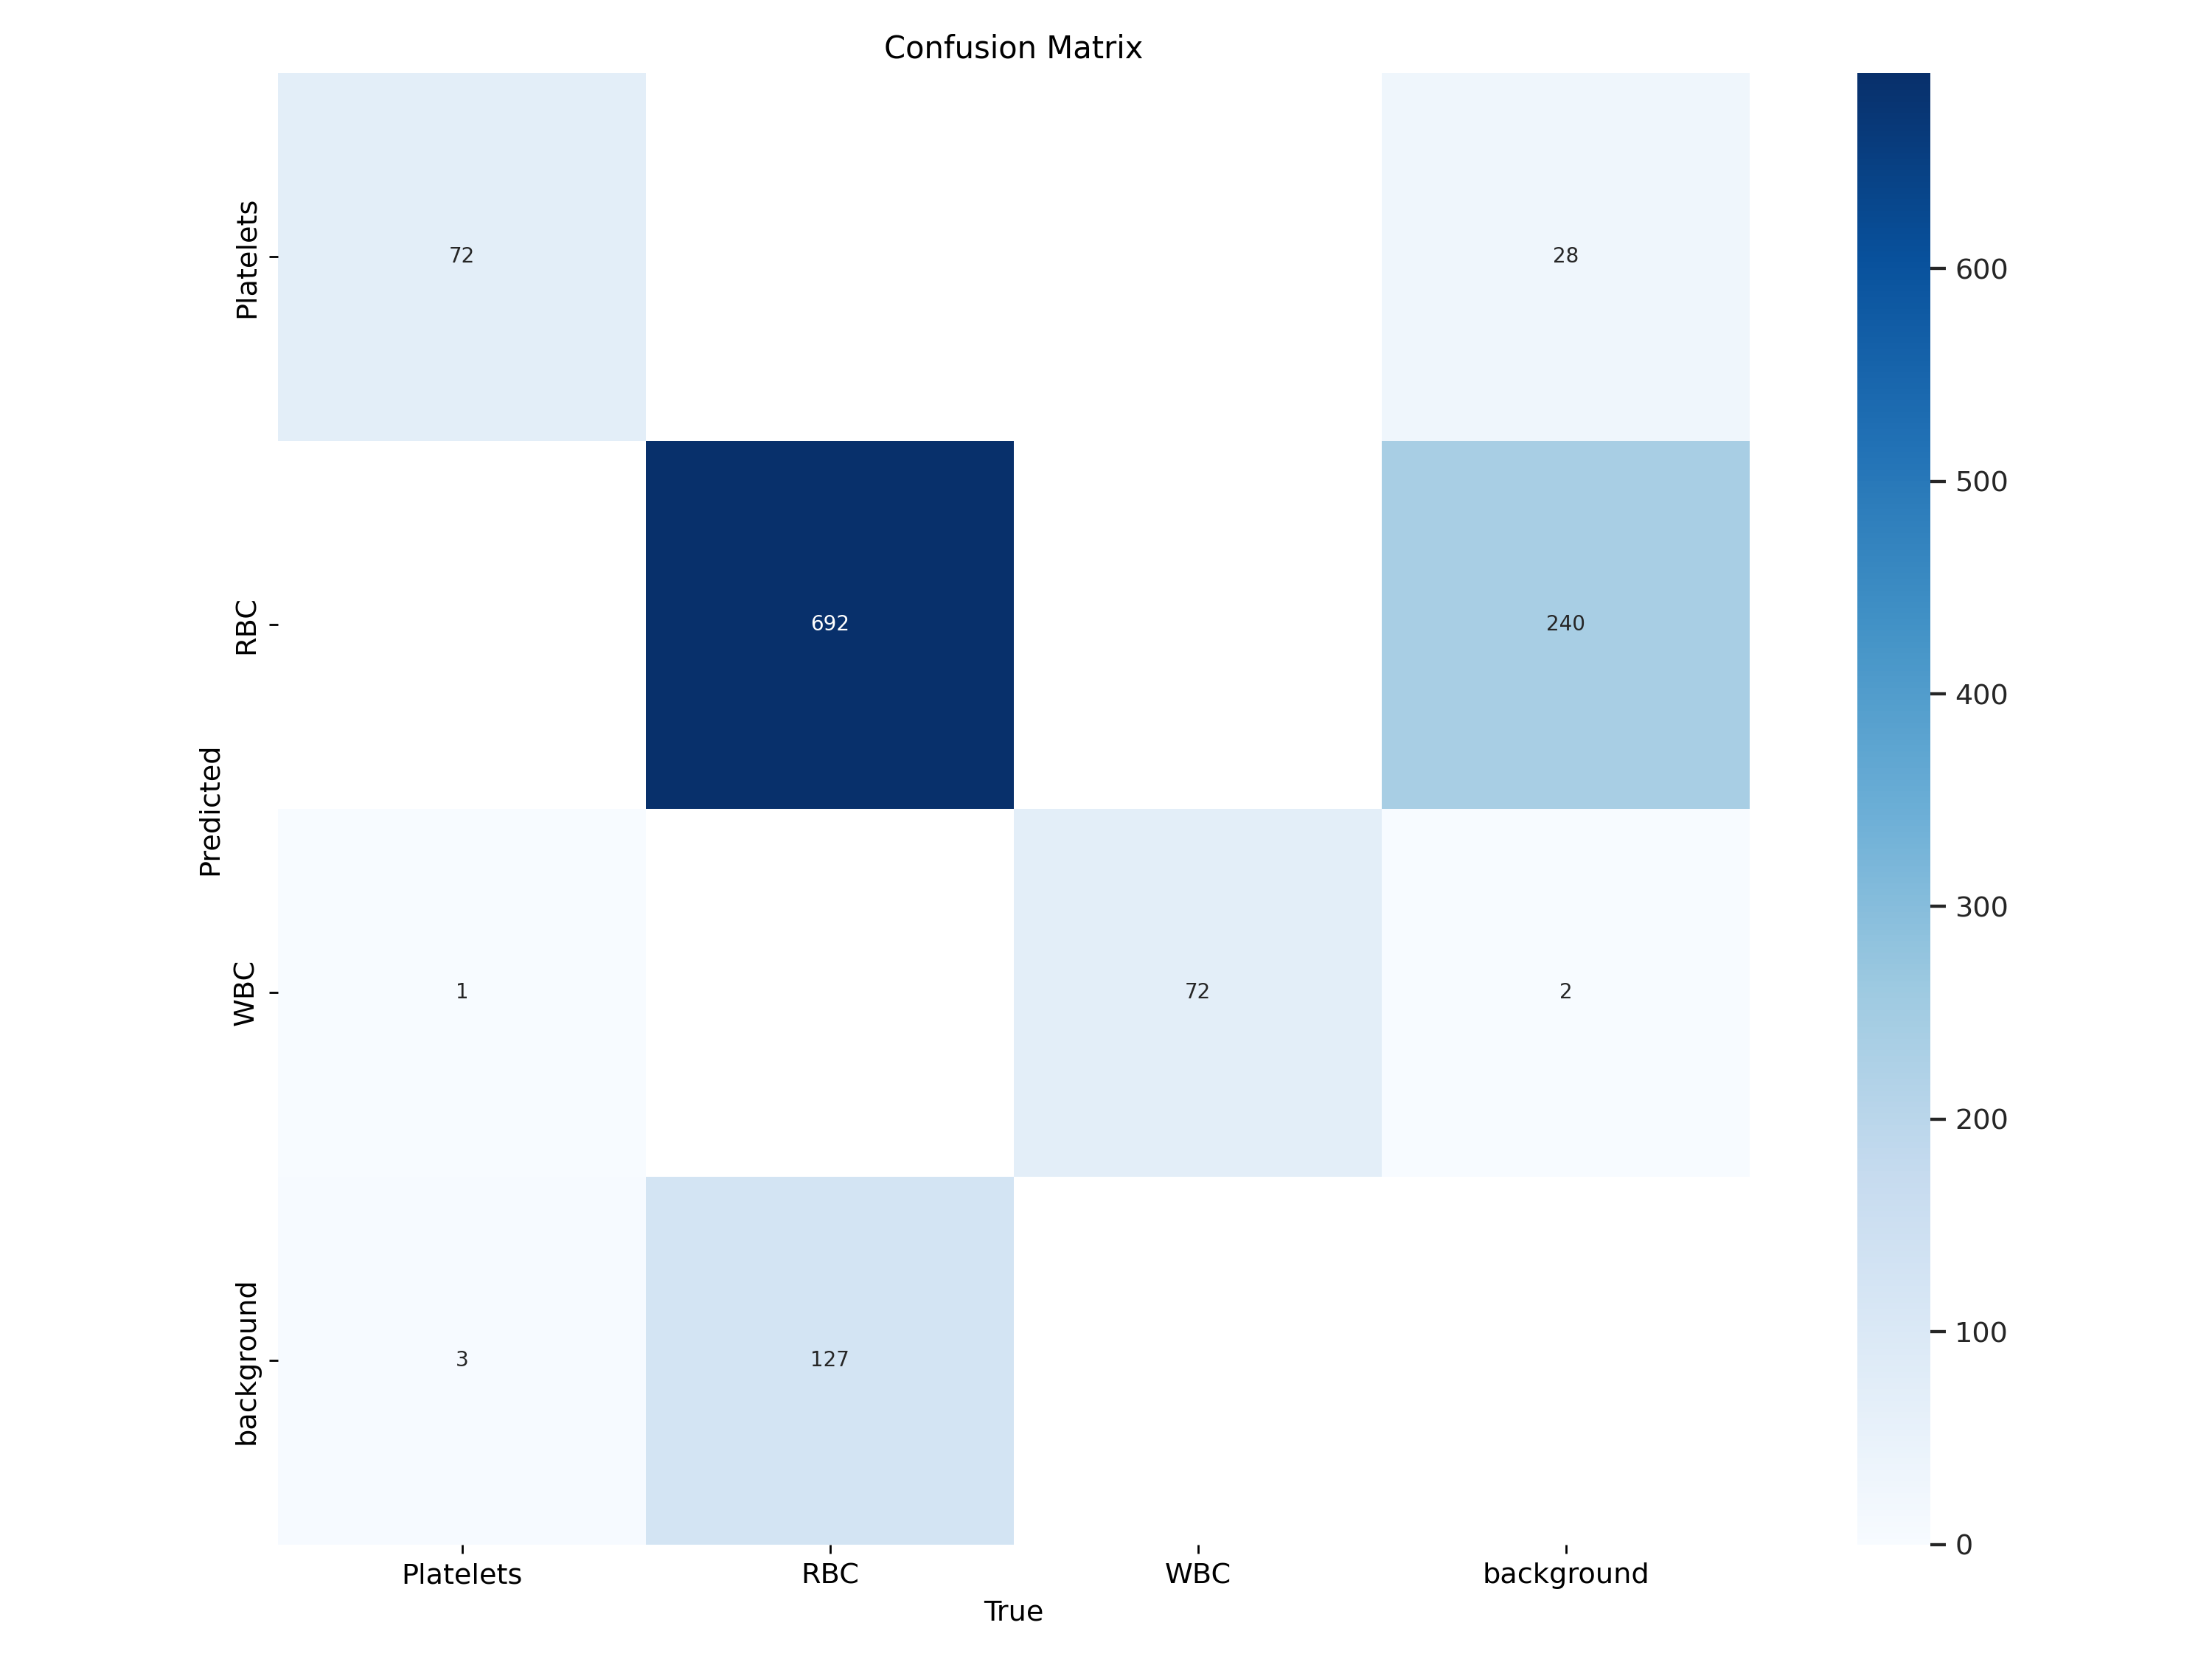

In [4]:
Image.open(f"runs/detect/train/confusion_matrix.png")

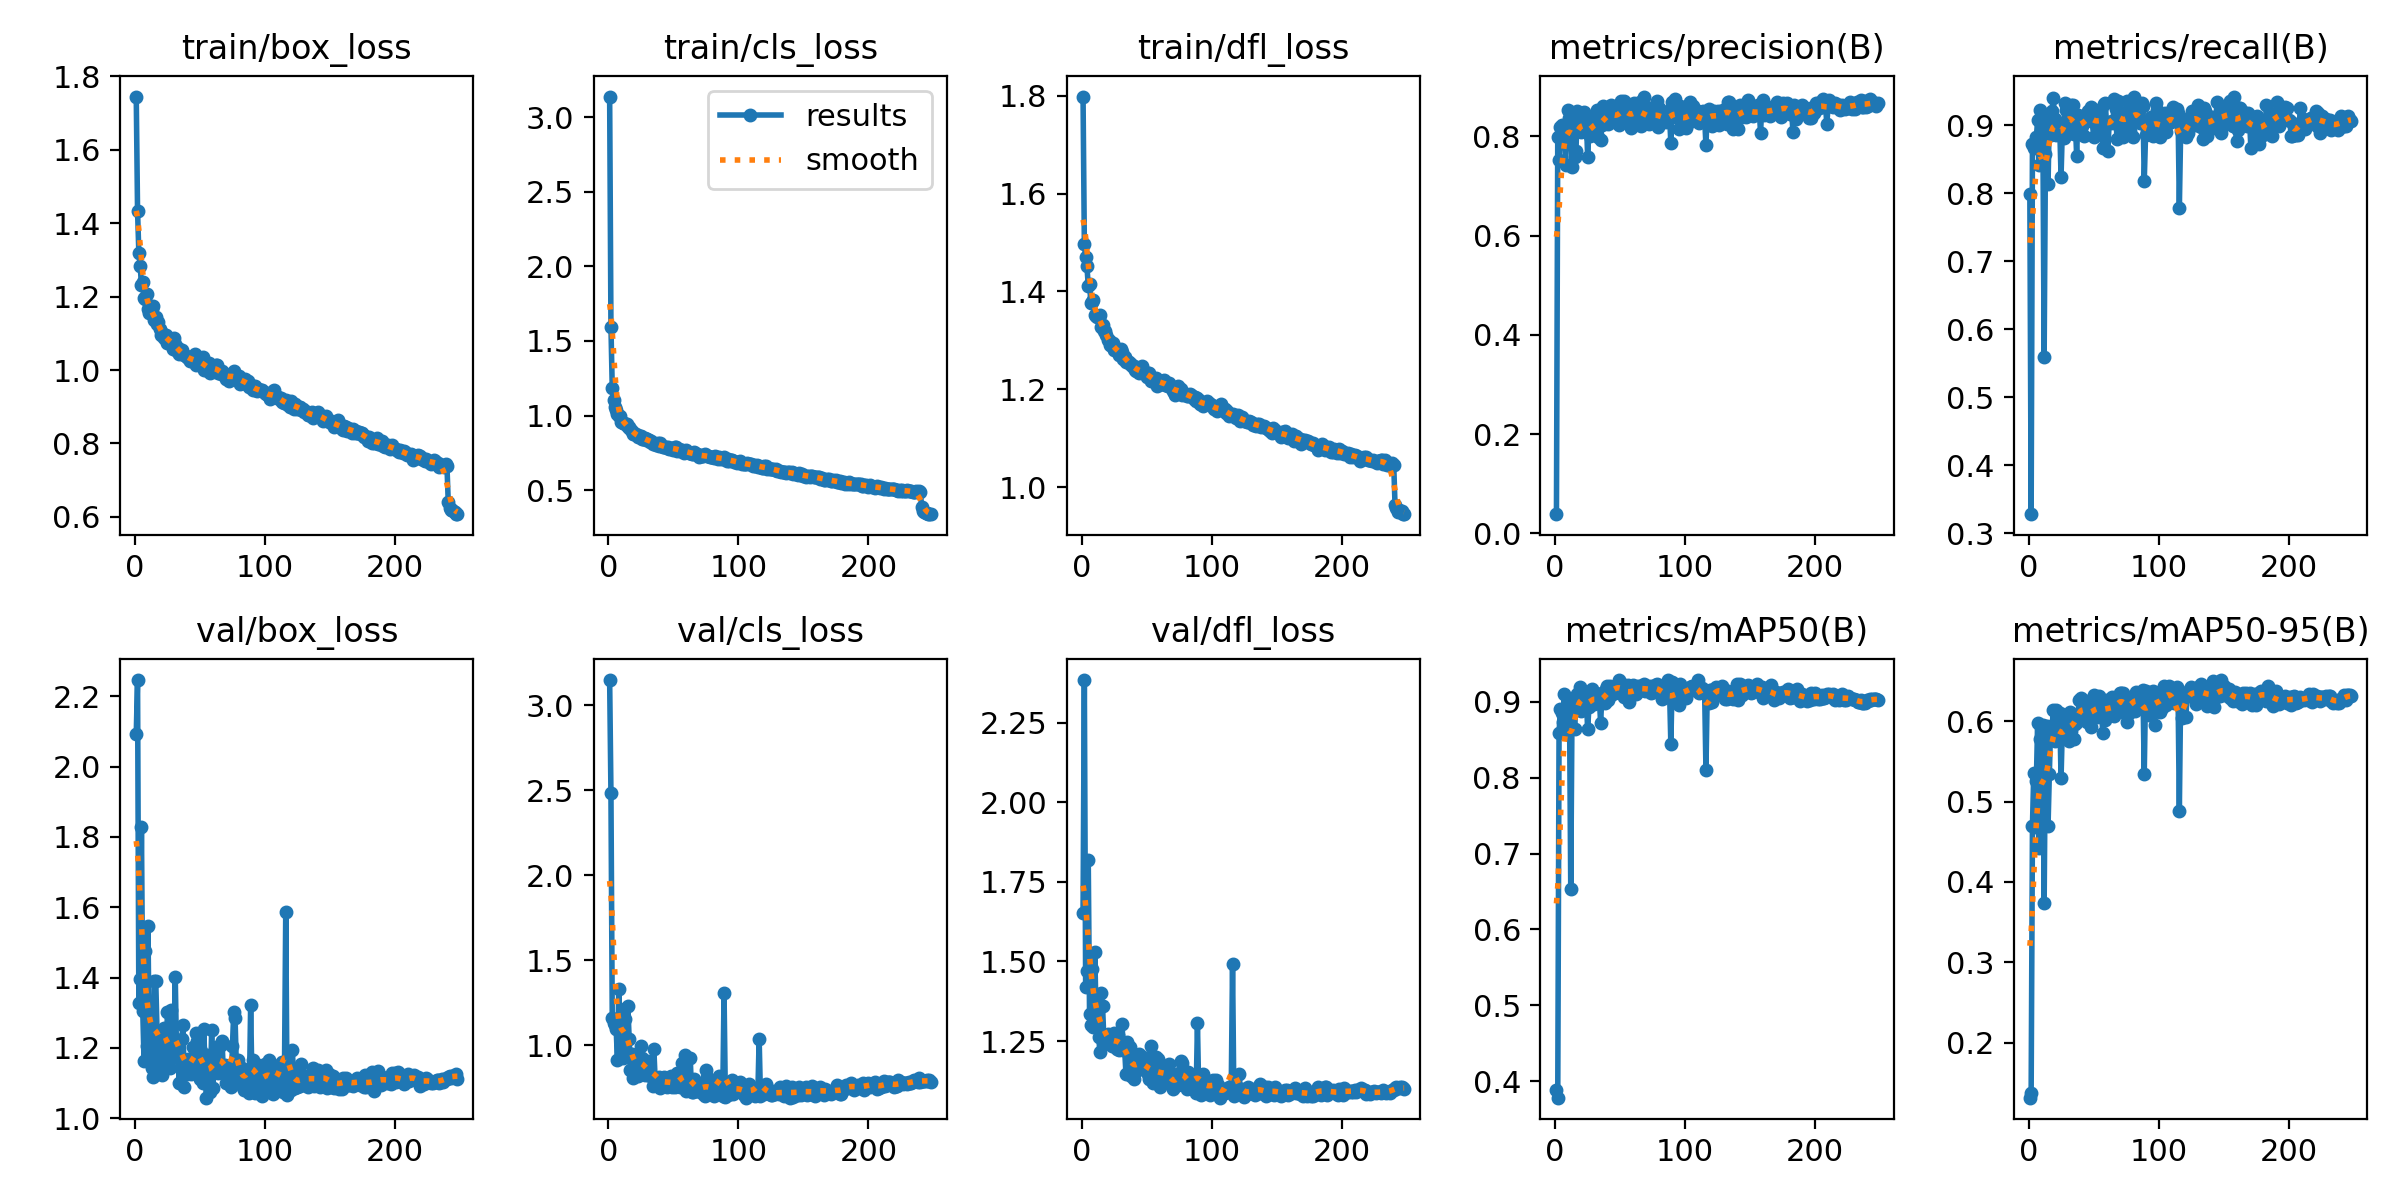

In [5]:
Image.open(f"runs/detect/train/results.png")

# Tests set

In [6]:
metrics = model.val(
    data="datasets/data.yaml",
    split="test",
    imgsz=416
)

Ultralytics 8.3.126 🚀 Python-3.10.14 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 1.9±0.6 ms, read: 3.2±0.8 MB/s, size: 12.4 KB)


val: Scanning /opt/app/datasets/test/labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


                   all         36        471      0.856      0.848       0.88      0.608
             Platelets         20         36      0.746      0.833      0.797      0.402
                   RBC         34        398      0.859      0.737      0.866      0.619
                   WBC         35         37      0.962      0.973      0.976      0.803
Speed: 0.7ms preprocess, 10.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train2



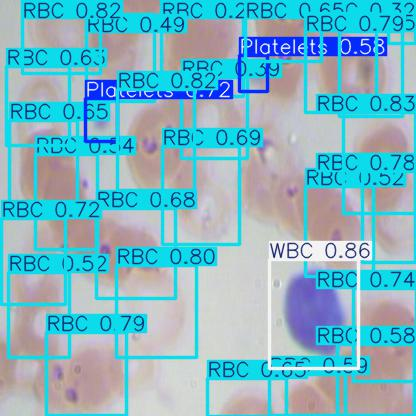
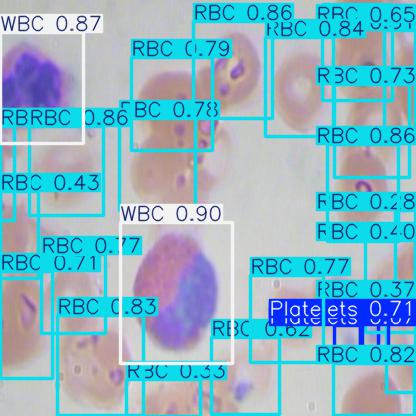
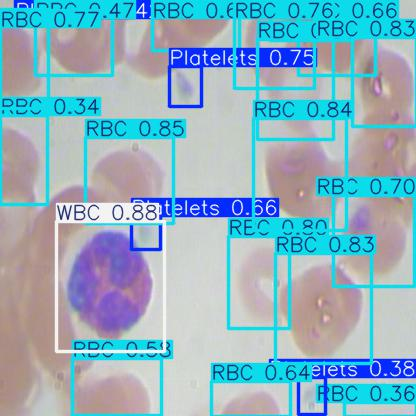
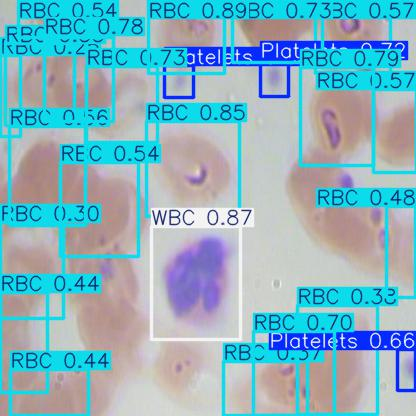
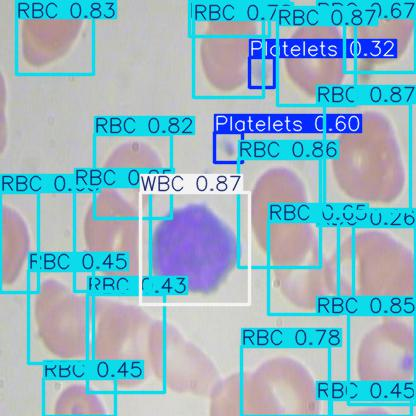
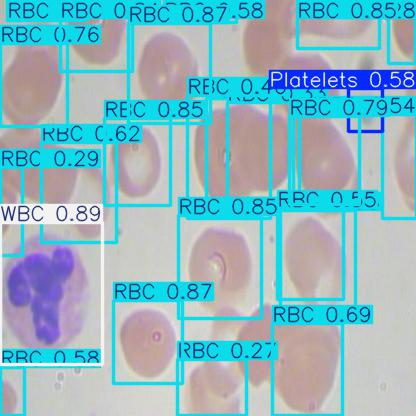
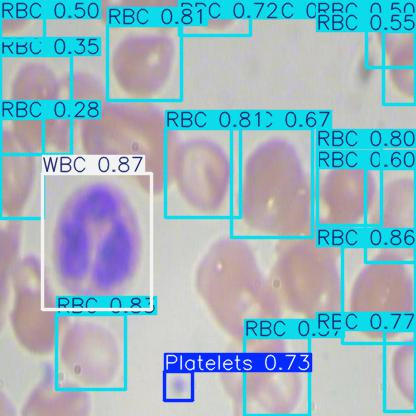
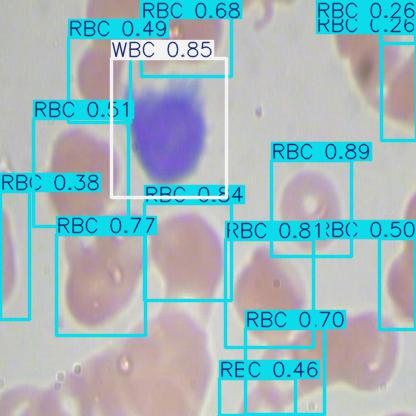
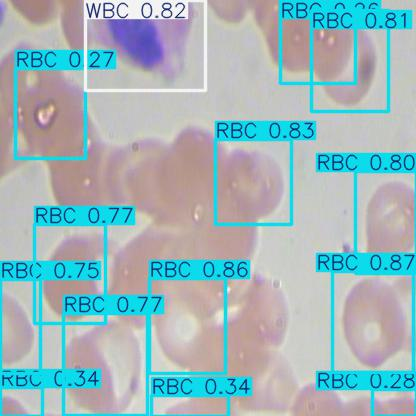
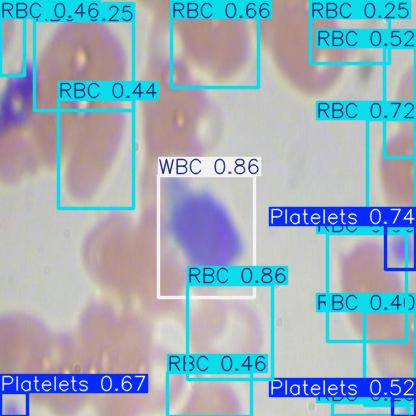
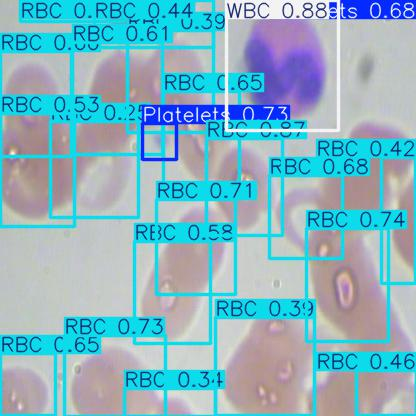
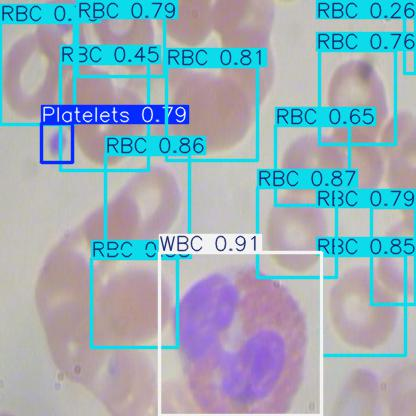
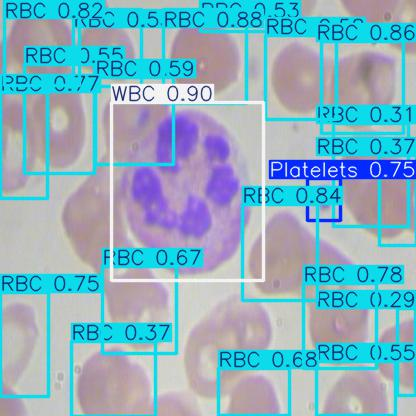
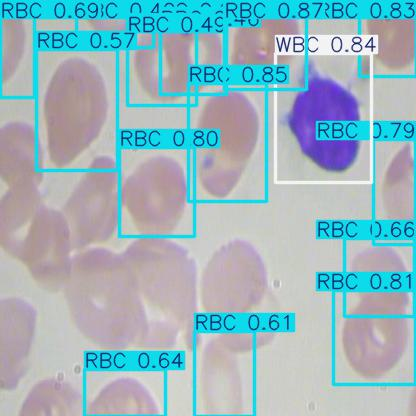
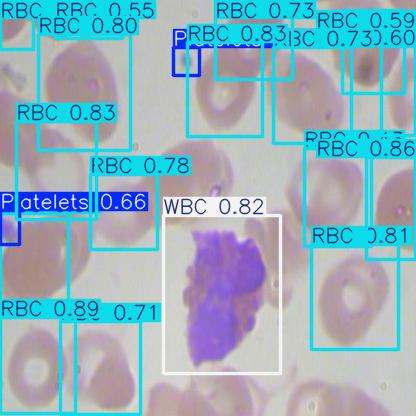
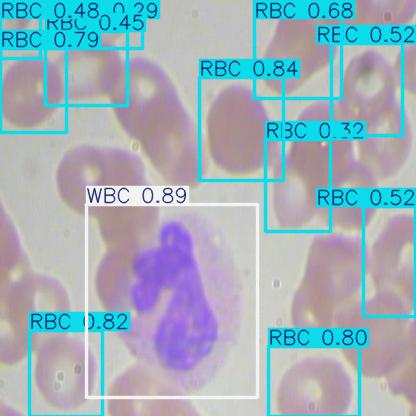
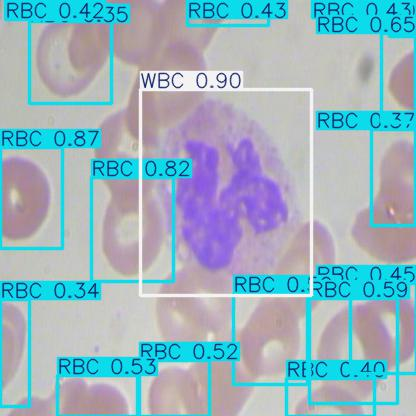
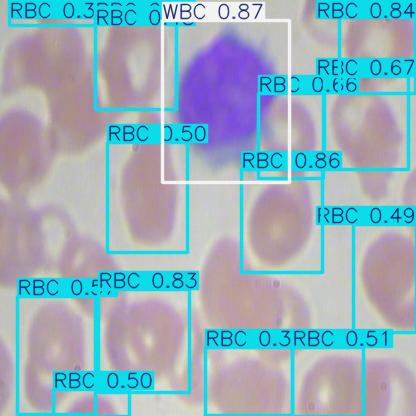
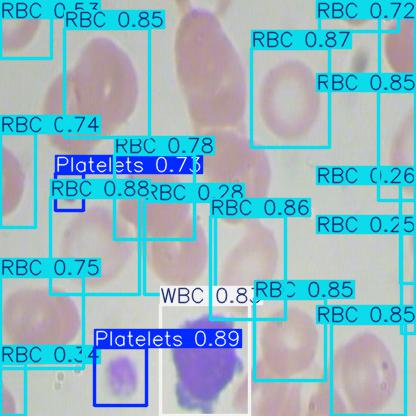
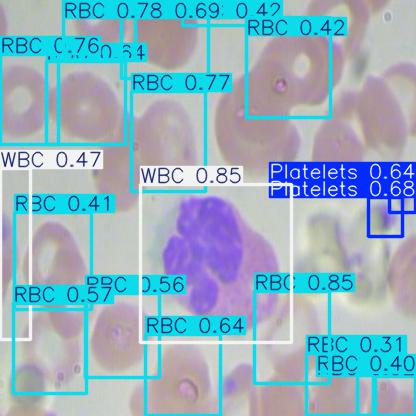
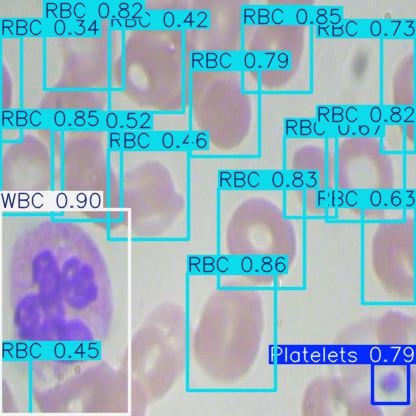
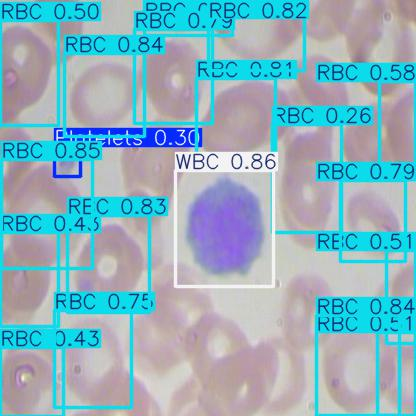
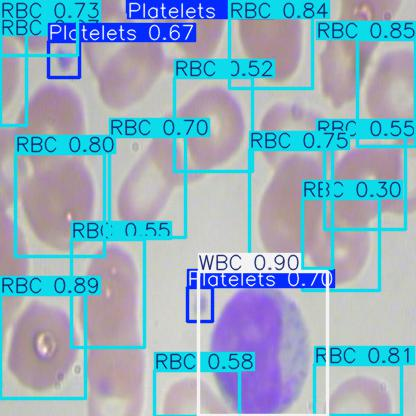
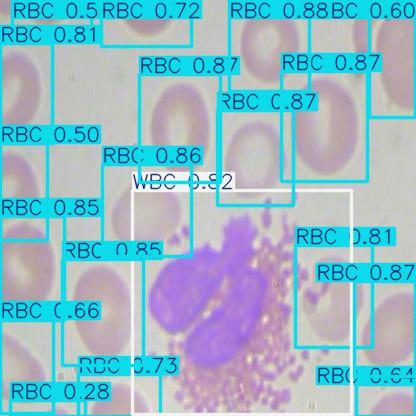
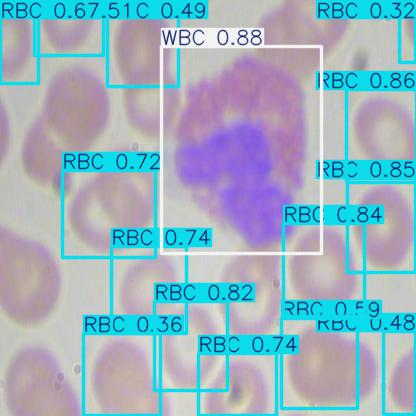
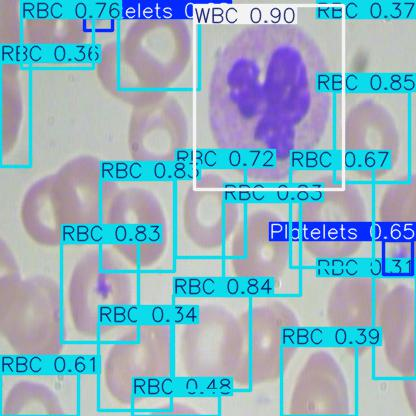
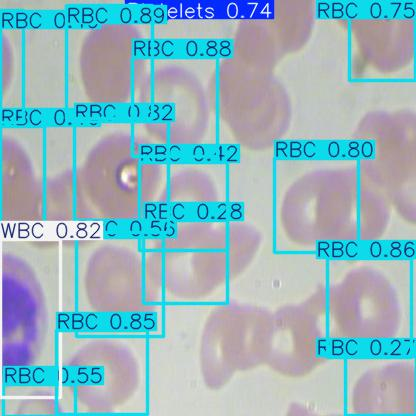
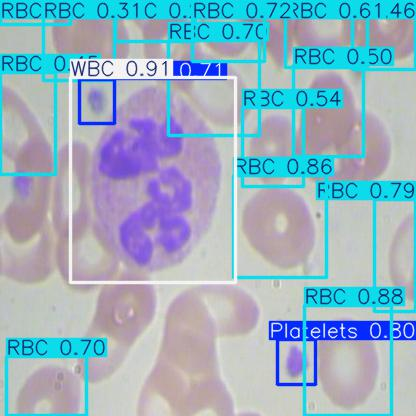
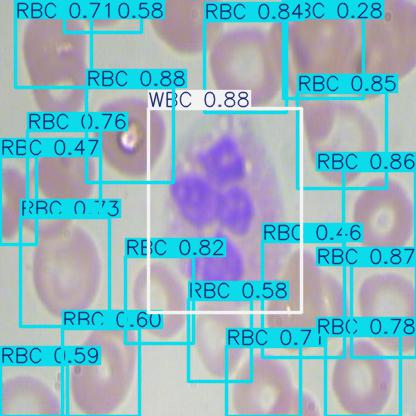
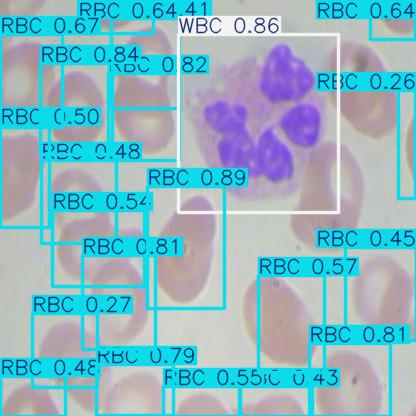
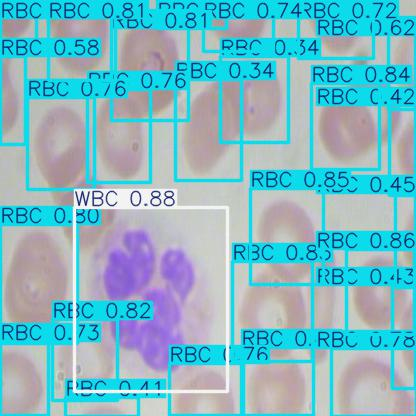
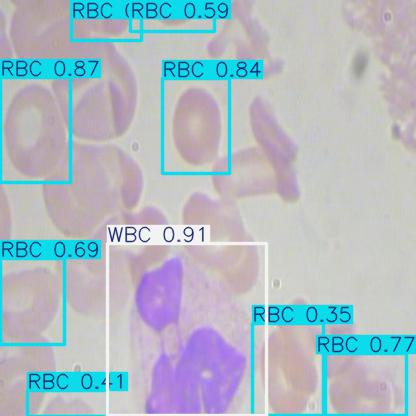
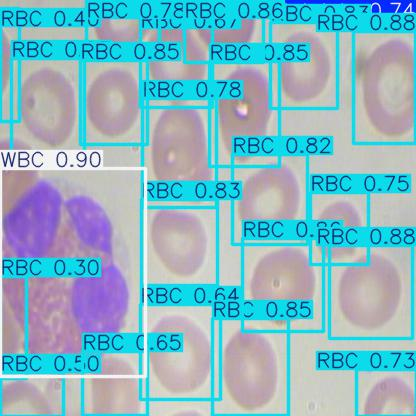
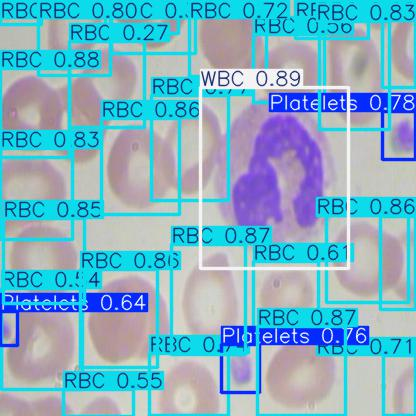
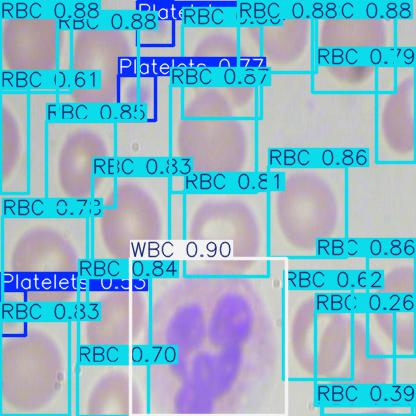
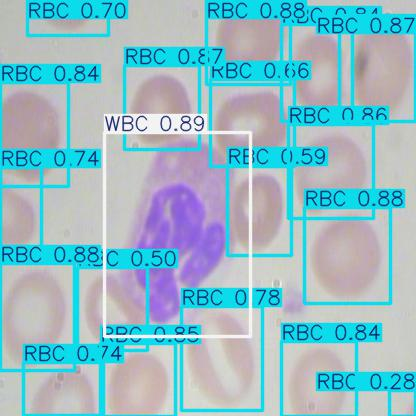

In [7]:
inference_results = model("datasets/test/images", conf=0.25, verbose=False)
plot(inference_results, 4)

# Dataset filtering

My first thought was to remove images without the RBC class from the collection (it is these objects that are always present). However, let's first see the number of labelled objects in general:

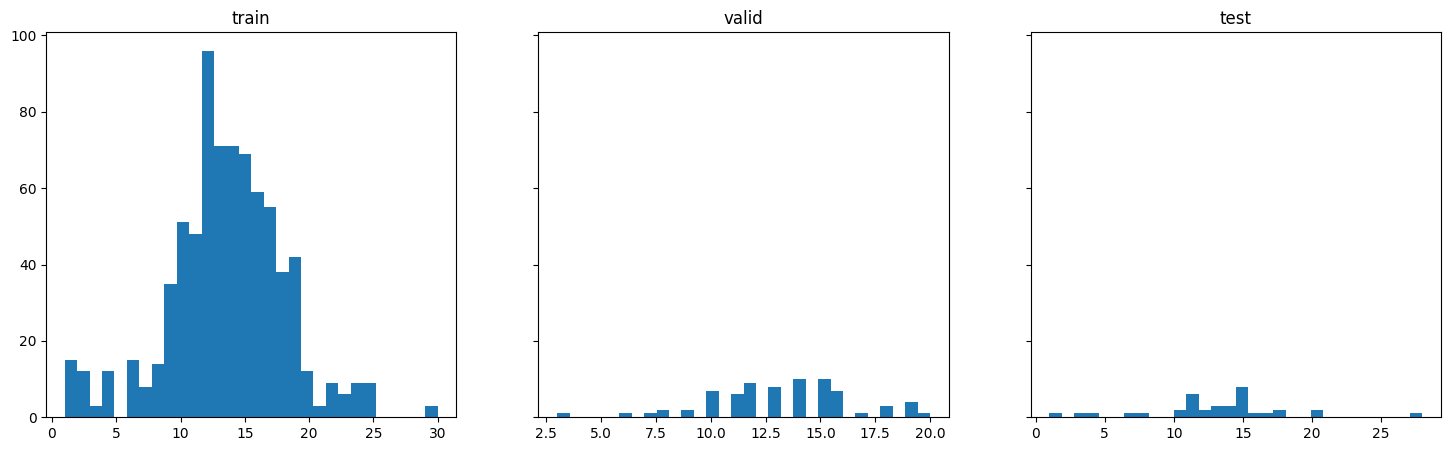

In [22]:
%matplotlib inline

import yaml
import glob2
import matplotlib.pyplot as plt

how_many = {}
for data_group in glob2.glob("./datasets/*/"):
    how_many[data_group] = []
    for case_file in glob2.glob(data_group + 'labels/*.txt'):
        with open(case_file, 'rt') as f:
            content = f.read()
            
            count = len(content.split("\n"))
            how_many[data_group].append(count)

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

_ = axs[0].hist(how_many['./datasets/train/'], bins=30)
_ = axs[0].set_title("train")
_ = axs[1].hist(how_many['./datasets/valid/'], bins=30)
_ = axs[1].set_title("valid")
_ = axs[2].hist(how_many['./datasets/test/'], bins=30)
_ = axs[2].set_title("test")

# fig

Manually checking the files with less than 9 labelled objects led me to the decision to either review all these examples and improve the labelling or filter them out. Since in this analysis I am assuming that I do not have a domain expert available, nor am I myself going beyond the scope of my remit defined as AI decides to filter them out.

The removal of data from the test collection is very controversial. I perform such an operation in the knowledge that the results on the modified ‘test’ cannot be used without the agreement of the author of the challenge to compare the strength of the detector.

This reduces the sets:
- Training 
    - from 765 images to 686 (89.7%)
- Validation:
    - from 73 images to 68 (93.2%)
- Testing:
    - from 36 images to 31 (86.1%)

In [9]:
import os
import shutil

with open("./datasets/data.yaml", "r") as file:
    data = yaml.safe_load(file)

shutil.rmtree("./datasets/filtered_train")
shutil.rmtree("./datasets/filtered_valid")
shutil.rmtree("./datasets/filtered_test")

os.makedirs("./datasets/filtered_train/images")
os.makedirs("./datasets/filtered_train/labels")

os.makedirs("./datasets/filtered_valid/images")
os.makedirs("./datasets/filtered_valid/labels")

os.makedirs("./datasets/filtered_test/images")
os.makedirs("./datasets/filtered_test/labels")

for data_group in glob2.glob("./datasets/*/"):
    for case_file in glob2.glob(data_group + 'labels/*.txt'):
        with open(case_file, 'rt') as f:
            content = f.read()
            
            count = len(content.split("\n"))

            if count >= 9:
                target_label = case_file.replace("./datasets/", "./datasets/filtered_")
                source_image = case_file.replace("/labels/", "/images/").replace(".txt", ".jpg")
                target_image = source_image.replace("./datasets/", "./datasets/filtered_")
                
                shutil.copyfile(case_file, target_label)
                shutil.copyfile(source_image, target_image)
                
data['train'] = '../filtered_train/images'
data['val'] = '../filtered_valid/images'
data['test'] = '../filtered_test/images'

with open("datasets/data_filtered.yaml", "w") as file:
    yaml.dump(data, file, sort_keys=False)

# Traning a model on filtered data

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo12n.pt") # larger models did not achieve better metrics
train_results = model.train(
    data=f"./datasets/data_filtered.yaml",  
    epochs=250, 
    imgsz=416, 
    device=0, 
    
    scale=0.1,  # images in dataset have exactly the same zoom that augumentation should be very low. 
                # "Healthy red blood cells are about the same size, ranging from 6.2 to 8.2 micrometers"
                # so +-13%
    degrees=45, # The rotation of objects in the image is irrelevant. 
                # Therefore, in order to ensure that our model does not change the results with respect to rotation
    
    flipud=0.5, # that is already done by kaggle but I dont know how exactly, additional flipping will not break anything
    fliplr=0.5, # that is already done by kaggle but I dont know how exactly, additional flipping will not break anything
    hsv_s=0.0,  # that is already done by kaggle but I dont know how exactly
    hsv_v=0.0,  # that is already done by kaggle but I dont know how exactly
    hsv_h=0.0,  # that is already done by kaggle but I dont know how exactly
    
    dropout=0.3,
    translate=0.1,
    pretrained=True,
    mosaic=1.0,
    erasing=0
)

In [11]:
train_results.results_dict

{'metrics/precision(B)': 0.8688095600608001,
 'metrics/recall(B)': 0.9199818280381713,
 'metrics/mAP50(B)': 0.9244495351618292,
 'metrics/mAP50-95(B)': 0.6536338341062355,
 'fitness': 0.6807154042117949}

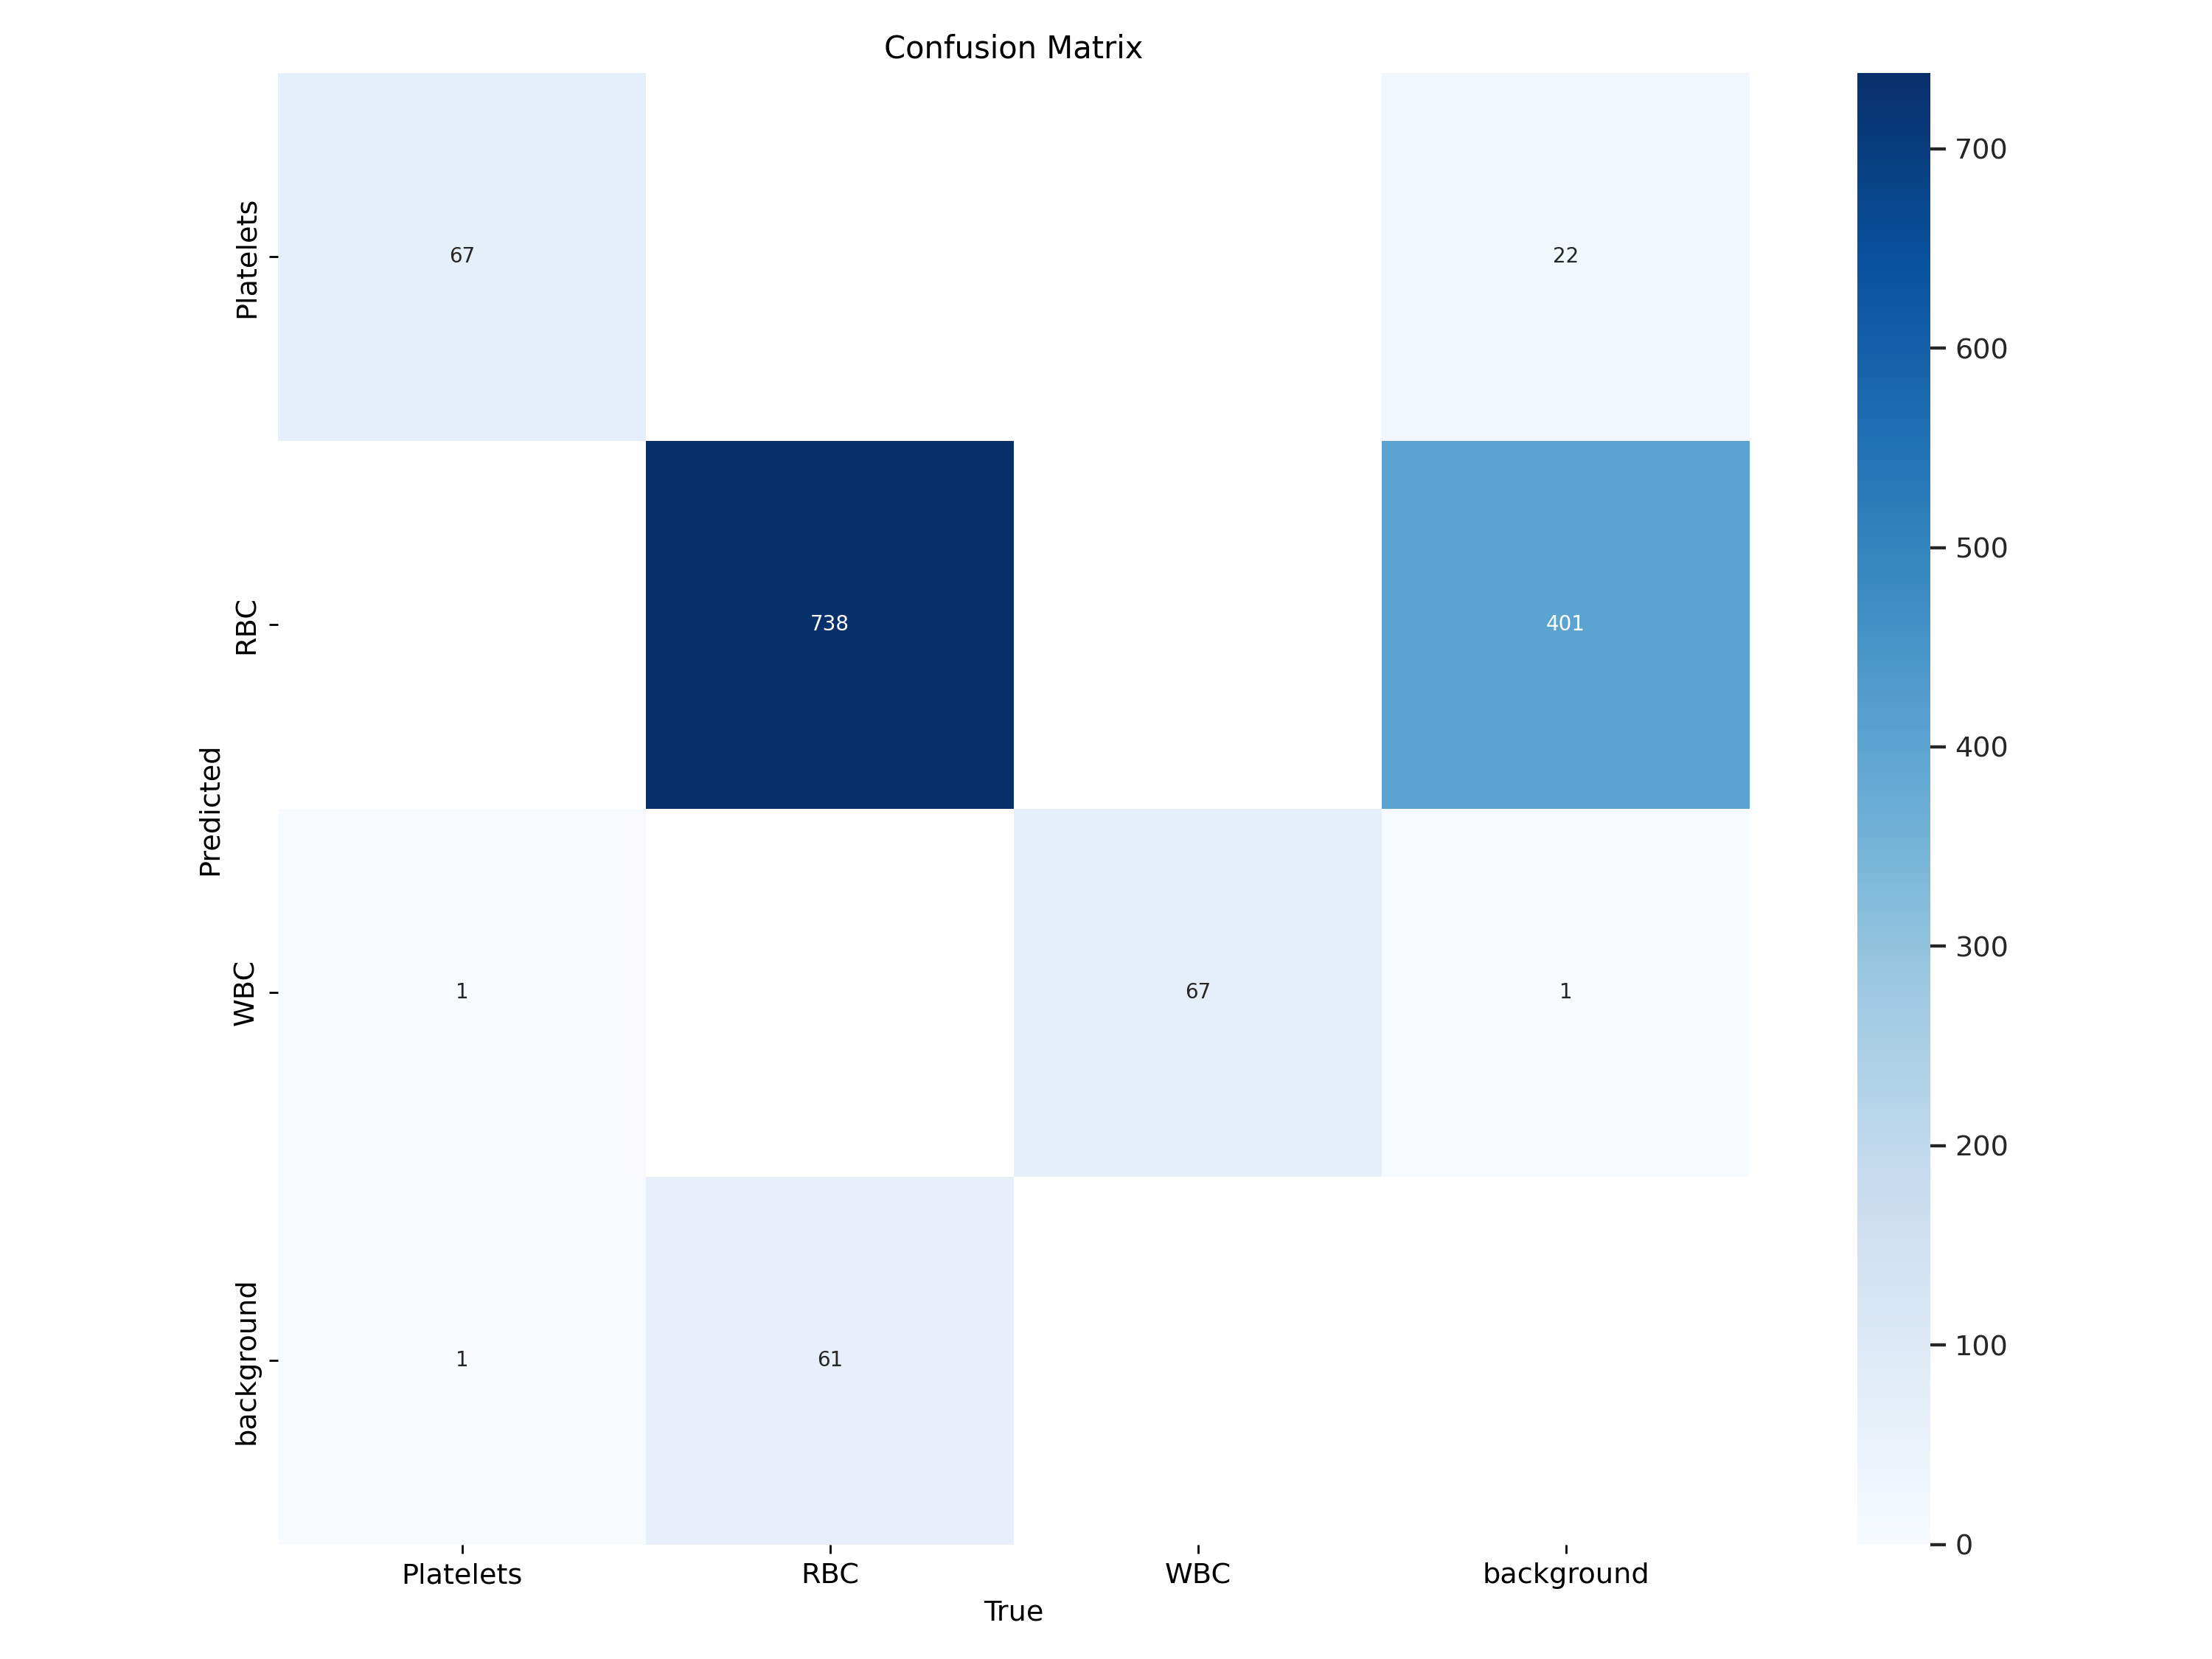

In [12]:
Image.open(f"runs/detect/train3/confusion_matrix.png")

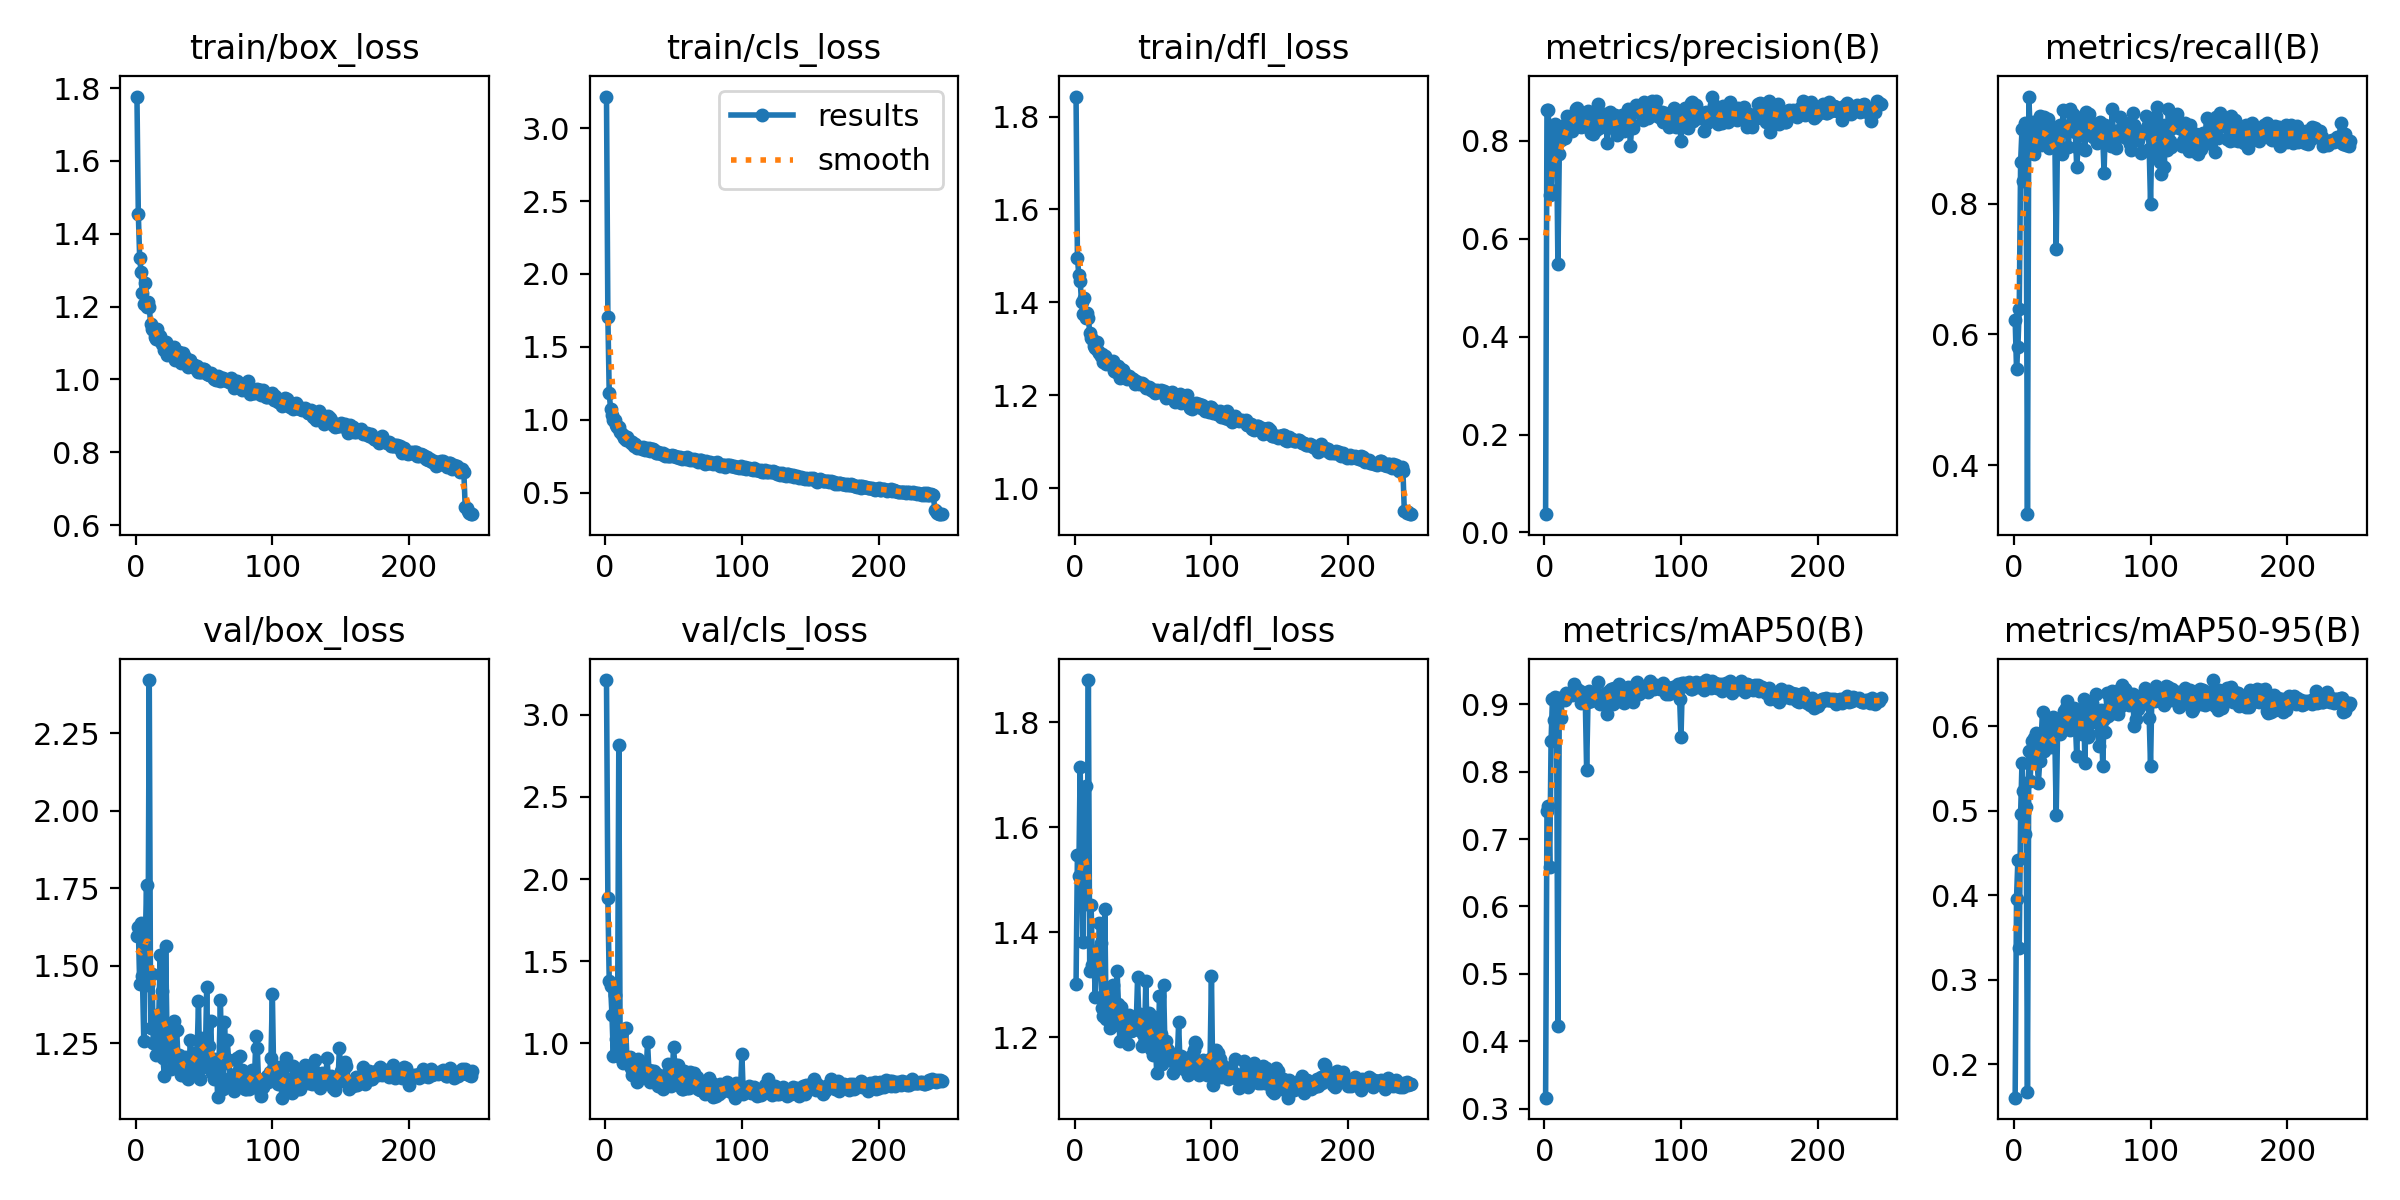

In [13]:
Image.open(f"runs/detect/train3/results.png")

# Checking trainset on model trained on filtered dataset

### On original testset

In [14]:
metrics = model.val(
    data="datasets/data.yaml",
    split="test",
    imgsz=416
)

Ultralytics 8.3.126 🚀 Python-3.10.14 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 1.8±0.8 ms, read: 4.7±1.1 MB/s, size: 12.4 KB)


val: Scanning /opt/app/datasets/test/labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


                   all         36        471      0.828      0.892      0.905      0.614
             Platelets         20         36      0.788      0.826      0.858      0.432
                   RBC         34        398      0.733      0.878      0.879      0.617
                   WBC         35         37      0.962      0.973      0.977      0.794
Speed: 0.7ms preprocess, 7.3ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/train32



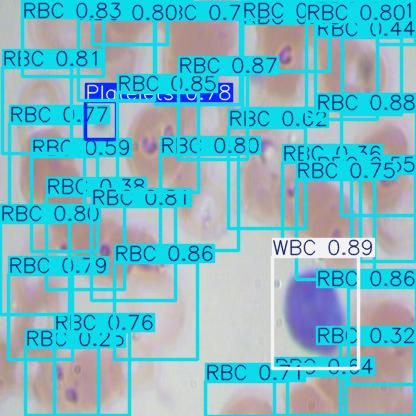
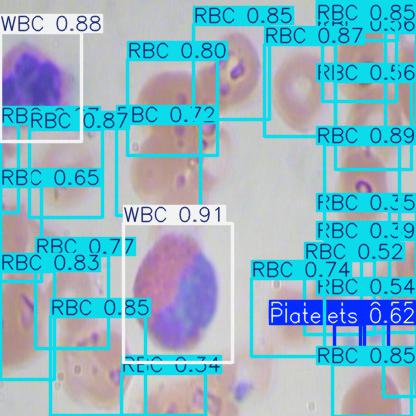
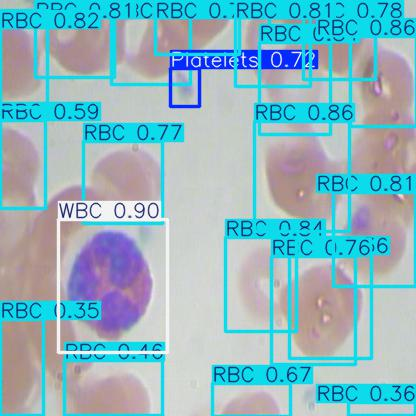
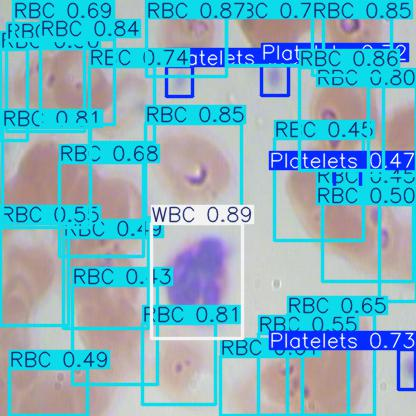
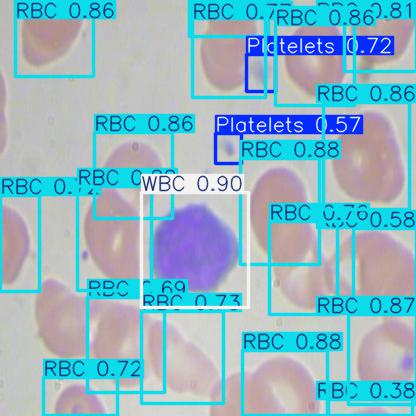
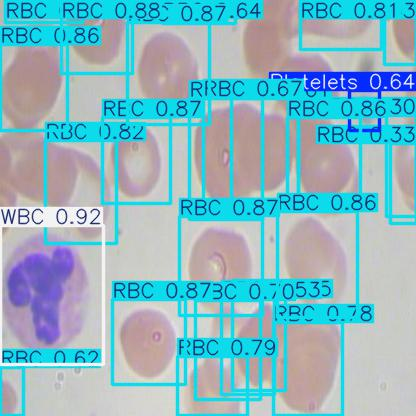
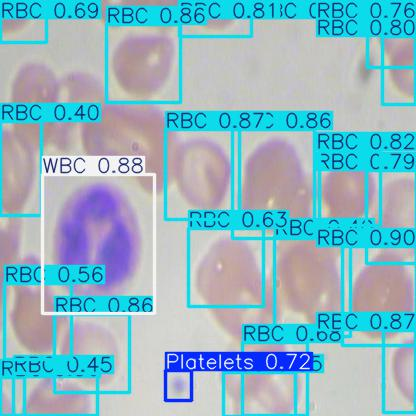
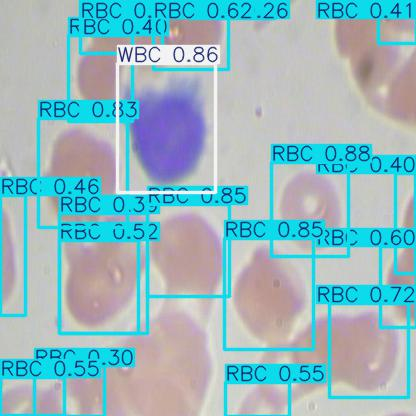
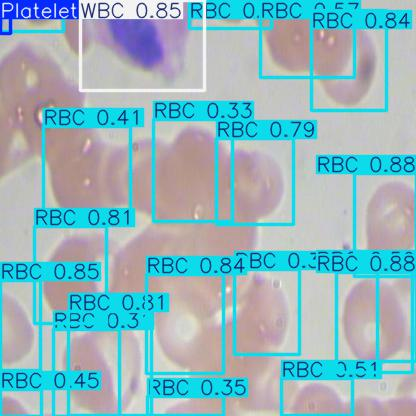
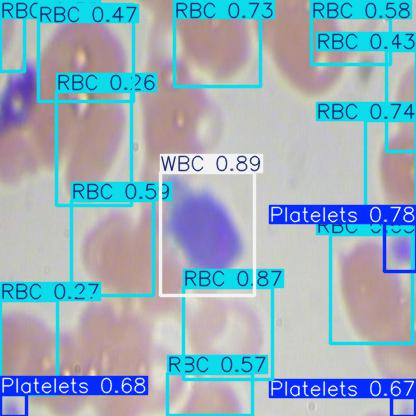
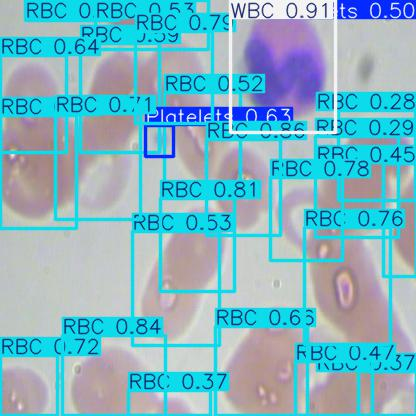
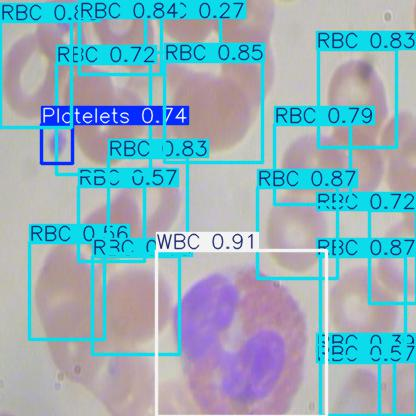
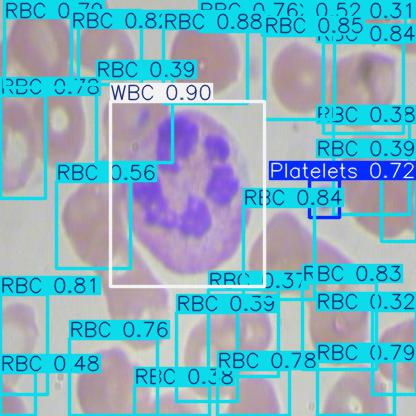
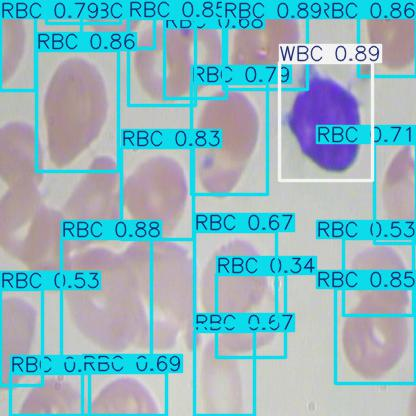
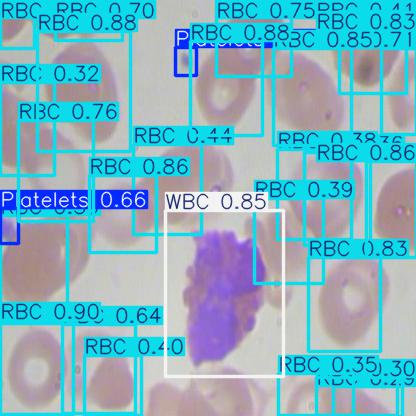
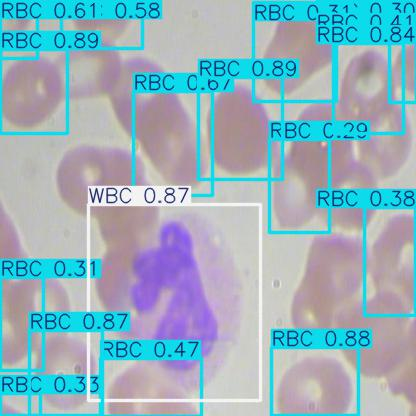
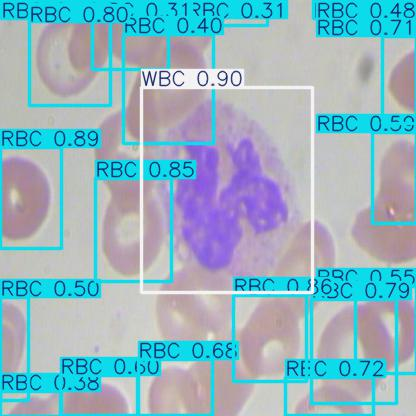
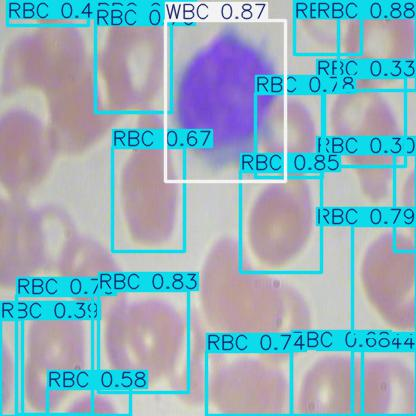
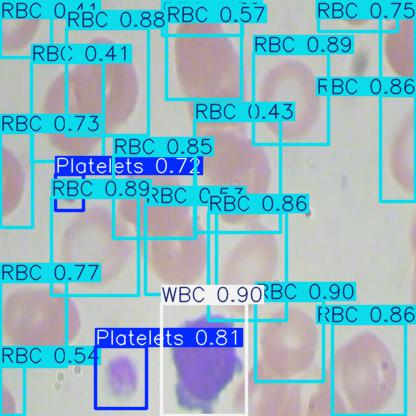
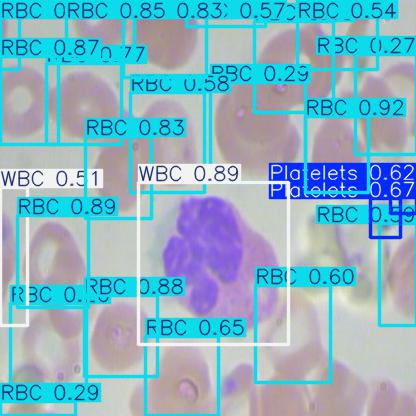
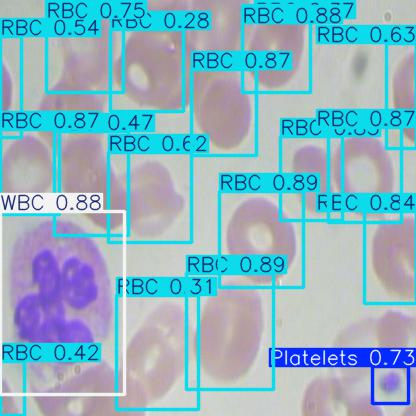
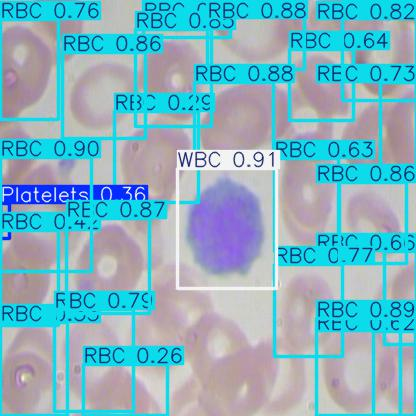
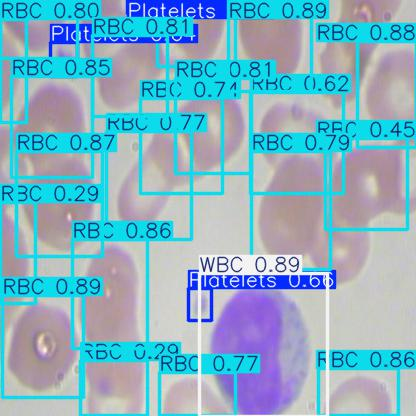
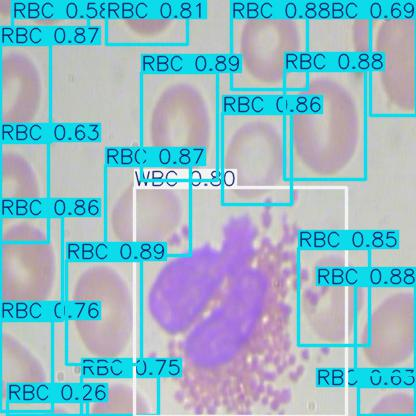
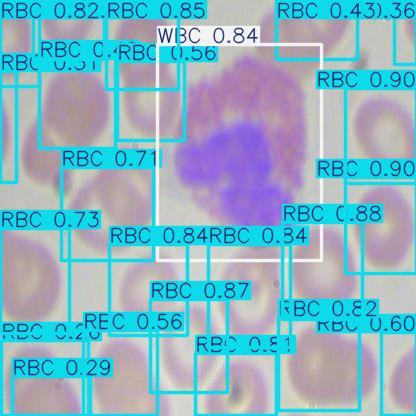
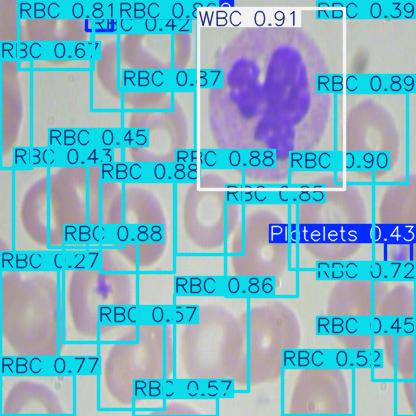
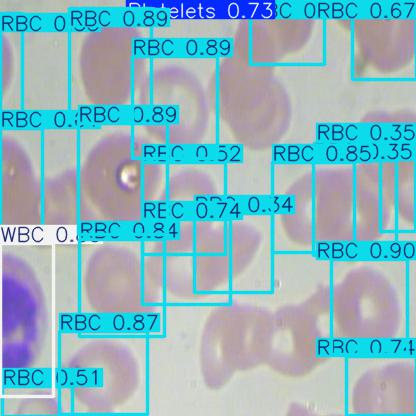
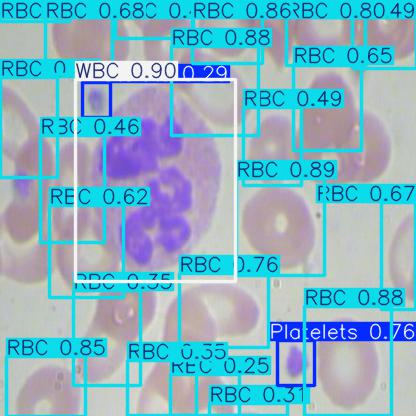
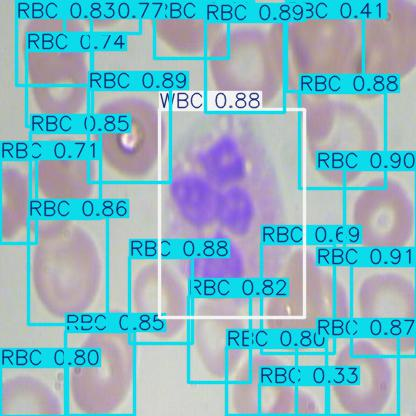
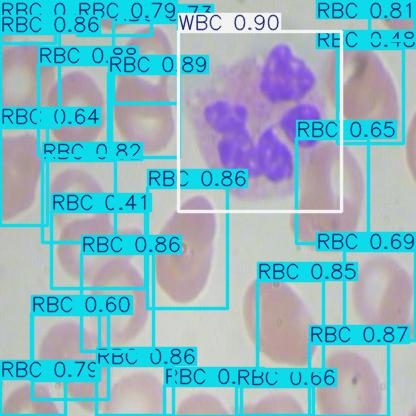
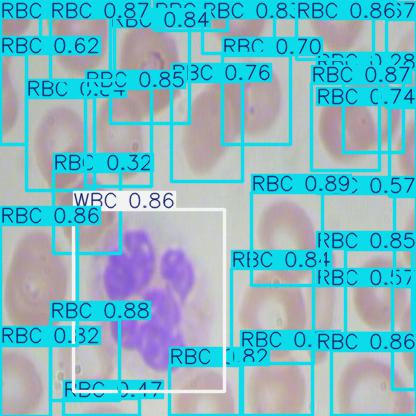
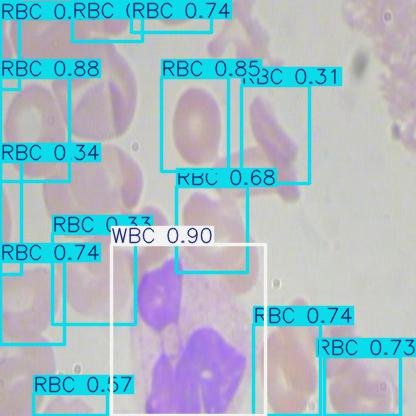
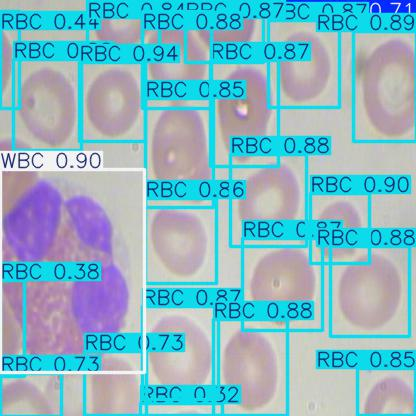
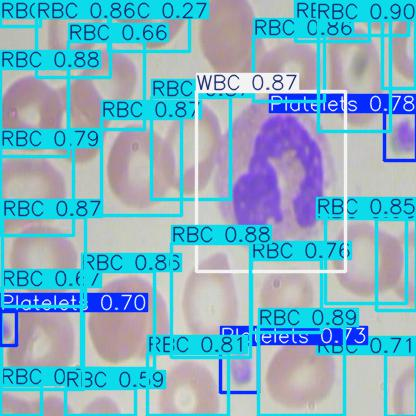
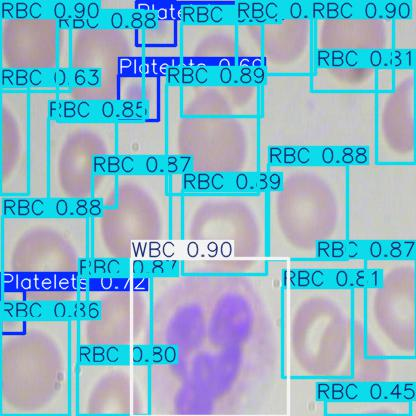
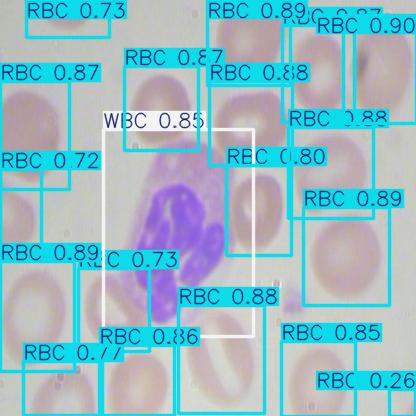

In [15]:
inference_results = model("datasets/test/images", conf=0.25, verbose=False)
plot(inference_results, 4)

### On filtered testset

In [16]:
metrics = model.val(
    data="datasets/data_filtered.yaml",
    split="test",
    imgsz=416
)

Ultralytics 8.3.126 🚀 Python-3.10.14 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
val: Fast image access ✅ (ping: 2.6±0.5 ms, read: 2.9±0.4 MB/s, size: 12.7 KB)


val: Scanning /opt/app/datasets/filtered_test/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 321.48it/s]


val: New cache created: /opt/app/datasets/filtered_test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


                   all         31        448      0.831      0.886      0.902       0.61
             Platelets         18         33       0.77      0.813       0.84      0.411
                   RBC         31        383      0.768      0.877      0.898      0.631
                   WBC         30         32      0.956      0.969      0.969      0.788
Speed: 0.6ms preprocess, 9.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train33



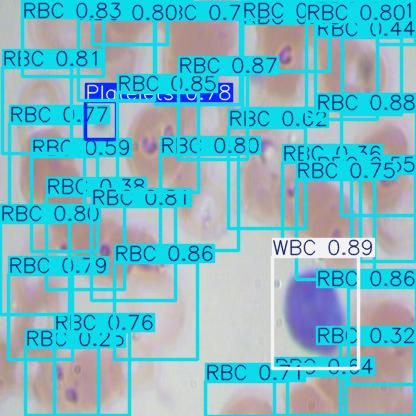
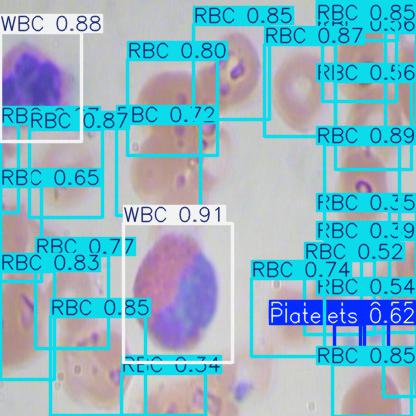
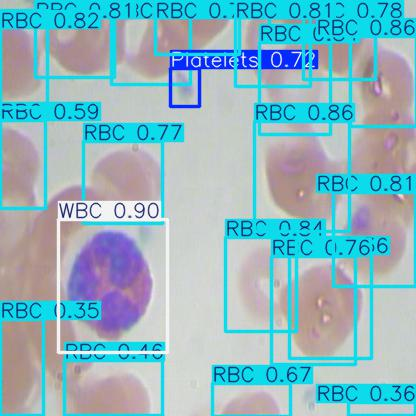
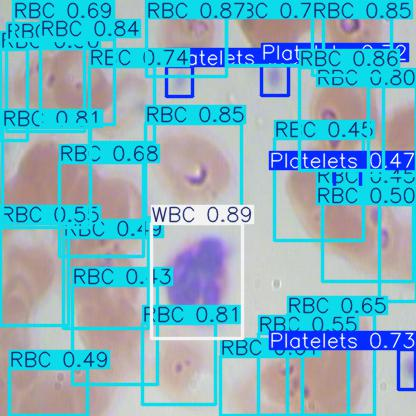
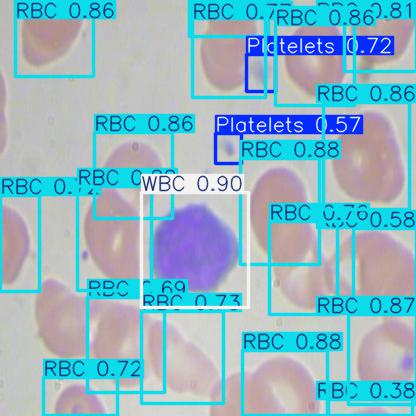
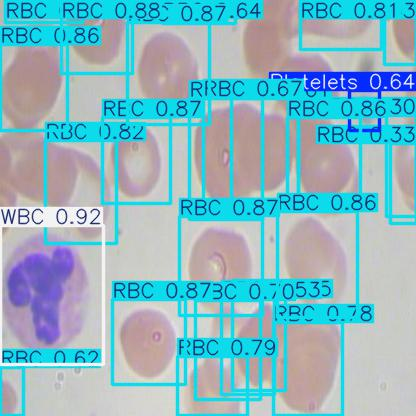
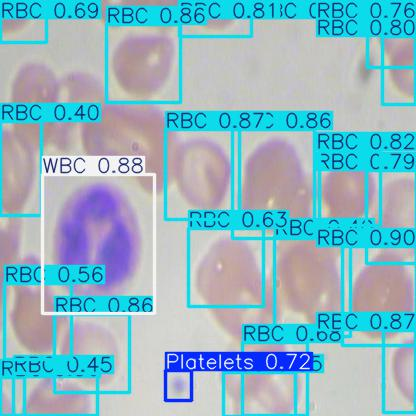
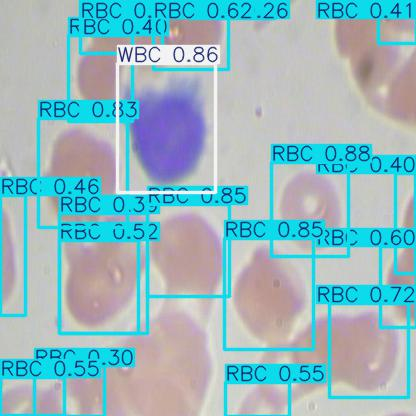
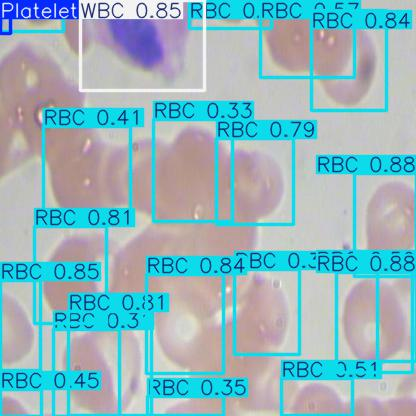
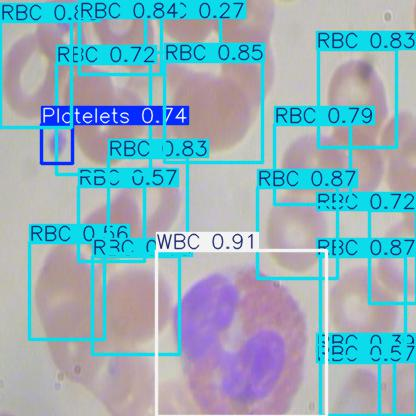
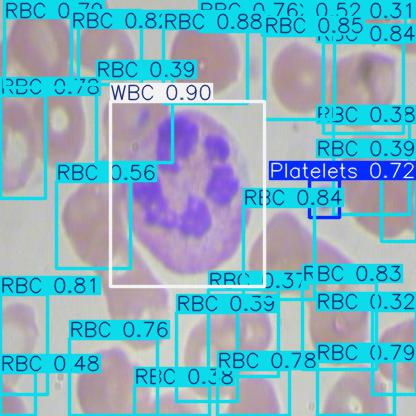
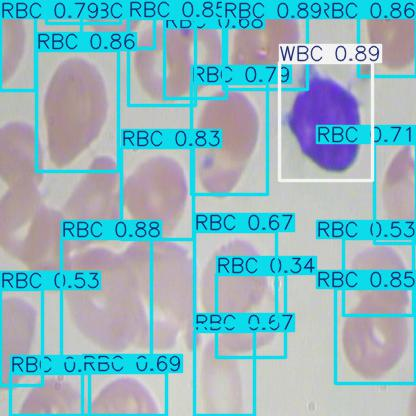
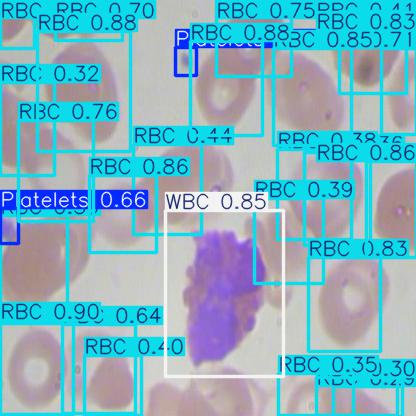
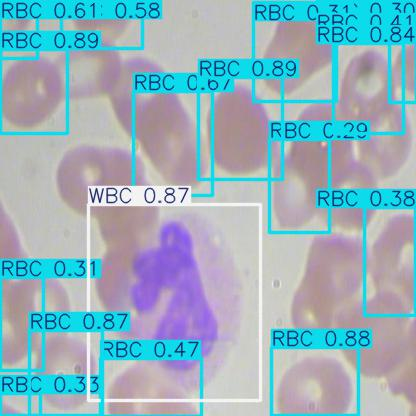
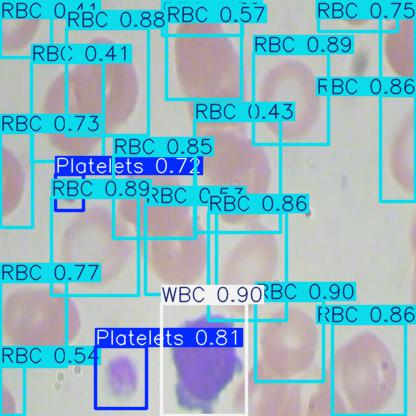
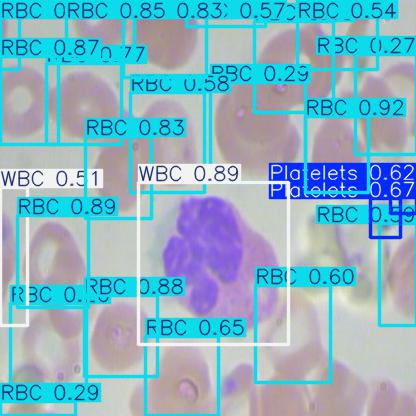
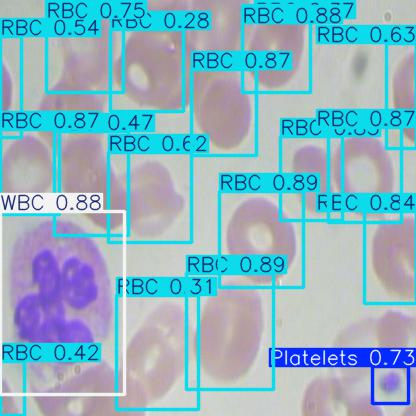
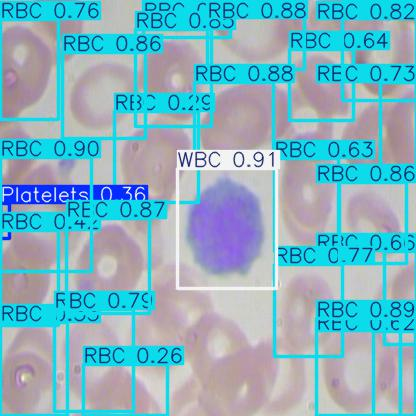
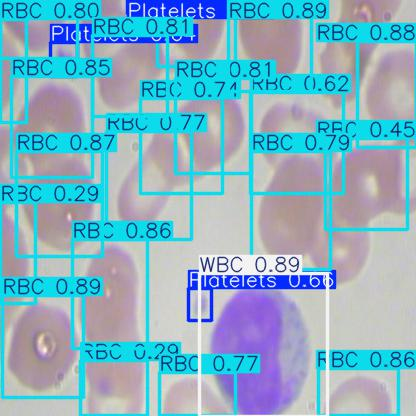
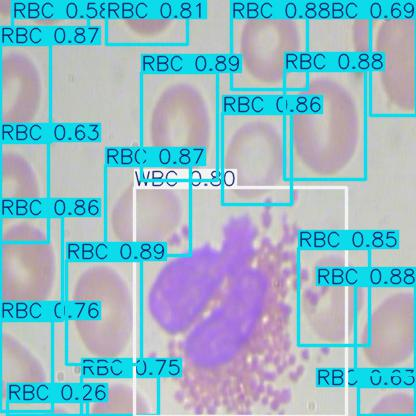
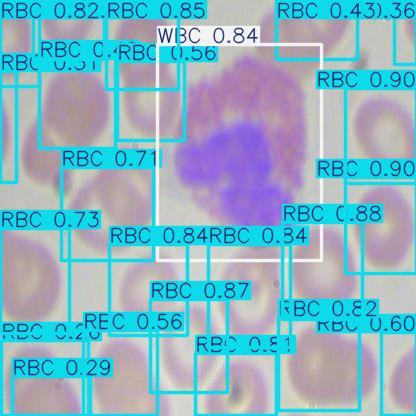
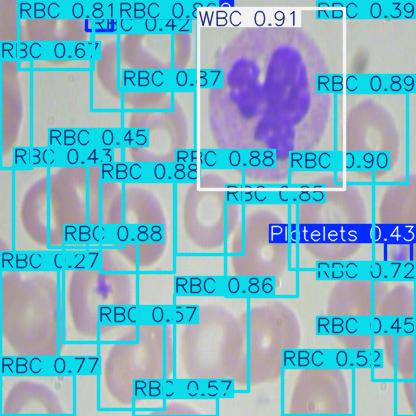
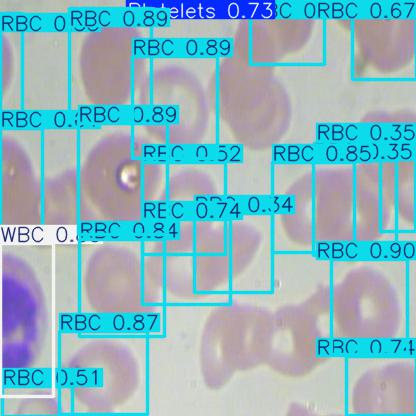
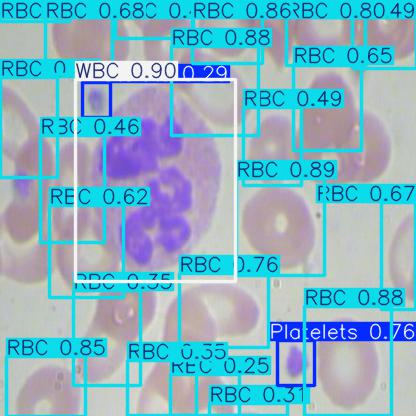
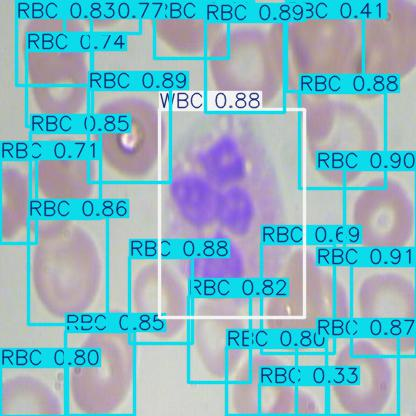
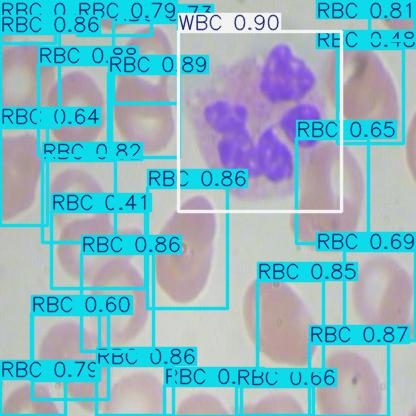
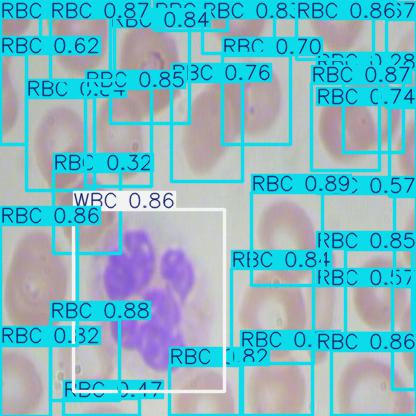
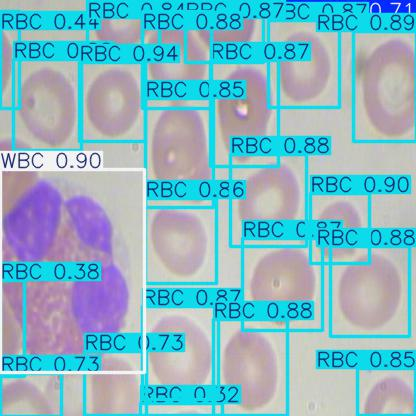
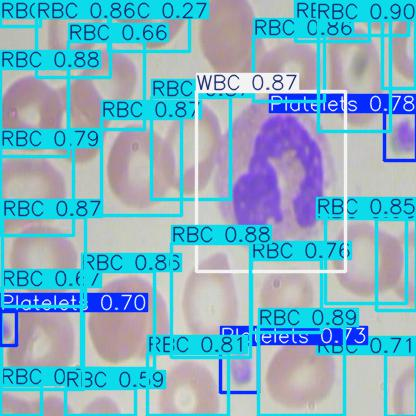
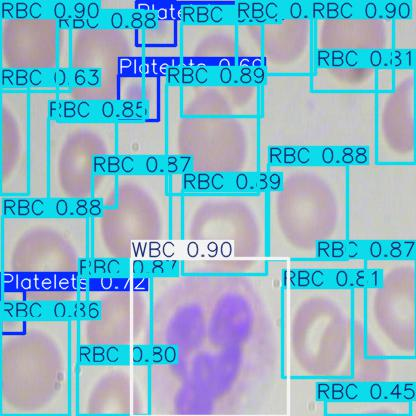
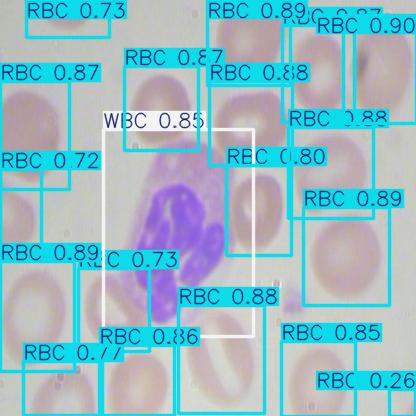

In [17]:
inference_results = model("datasets/filtered_test/images", conf=0.25, verbose=False)
plot(inference_results, 4)

# t-SNE

<Axes: xlabel='x', ylabel='y'>

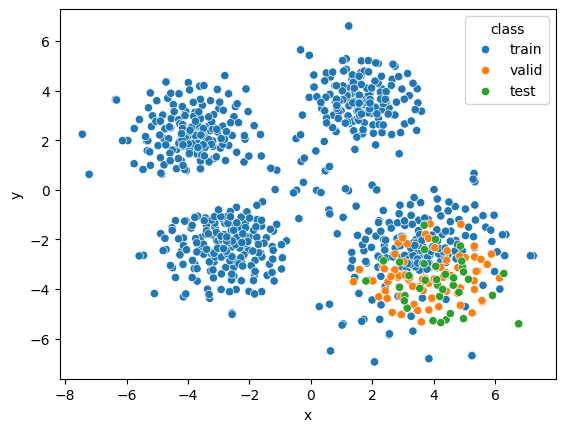

In [23]:
from torchvision import transforms
from sklearn.manifold import TSNE
import torch
import seaborn as sns
import pandas as pd

backbone = model.model.model[:model.model.nc].to('cuda')  # up to detection layer
backbone.eval()

transform = transforms.ToTensor()

image_paths = glob2.glob("datasets/train/*/*.jpg") + glob2.glob("datasets/valid/*/*.jpg") + glob2.glob("datasets/test/*/*.jpg") 
features = []
labels = []

for path in image_paths:
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to('cuda')

    with torch.no_grad():
        feat = backbone(input_tensor)[-1]
        pooled = feat.flatten().cpu().numpy()
        features.append(pooled)
        labels.append(path.split("/")[1])
        
features = np.array(features)

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

tsne_df = pd.DataFrame({
    'x': features_2d[:, 0],
    'y': features_2d[:, 1],
    'class': labels
})

sns.scatterplot(data=tsne_df, x='x', y='y', hue='class', palette='tab10')

A worrying symptom. I would expect all three collections to be similarly distributed in t-SNE.

It is good that there is also a good representation of ‘train’ in the cluster in which the valid/test set is located.

# Summary

I appreciate the effort put into completing this training collection and labelling it. The trained detector seems to have a high efficiency.  **The space for its improvement is primarily on the data side, not the processing method**.  

### Filtering

Filtering of the data showed that there was potential for improved detector power on the input side. The model trained on the filtered data on the unfiltered test set achieved mAP50=0.905 (the model trained on all data achieved mAP50=0.88)

### Pseudo-labeling

I would strongly suggest performing pseudo-labelling. This would realistically with little effort significantly increase the quality of the detector.